# August Perez Capstone Three Project:
## Characterization of High Accident Situations

Using neural networks / deep learning I plan on analyzing a conglomerate dataset to characterize what combined variables of road types, times, and conditions have the highest probability of a car accident occuring.

### Goal
Build models for characterization of locations with crash probability of >=80% (or top 10 if minimal quantity of >=80% crash probability)
and an analysis of times, days of the week, and dates of the year with crash probability >=60% for the locations characterized.

    Crash probability Thresholds chosen arbitrarily. For real-world application, each agency utilizing this needs to determine thresholds specific to their needs and capabilities.

### Data source:
Accidents in France from 2005 to 2016 (https://www.kaggle.com/datasets/ahmedlahlou/accidents-in-france-from-2005-to-2016/data)


    
#### About the dataset:
- A collection of 5 datasets pertaining to car crashes in France from 2005 to 2016
    - characteristics
        - Details about each crash
    - holidays
        - Dates from 2005 to 2016 that are holidays
    - places
        - Details about accident locations
    - users
        - Details about persons involved in the accident
    - vehicles
        - Details about vehicles involved in the accident

## Note on raw format cells:
Converted to raw format so the code within the cell won't execute. Kept the cell because it may have use for looking back on it in the future even if it did not have use within this project.

## Imports:

In [1]:
# data manipulation and math

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import datetime as dt

# plotting and visualization

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# modeling & pre-processing
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shap
shap.initjs() # print the JS visualization code to the notebook
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    #reminder code so I can ignore warnings for single code cells:
        # warnings.filterwarnings('ignore')
        # warnings.resetwarnings()

%matplotlib inline

In [2]:
import tensorflow as tf
import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, InputLayer, Flatten, concatenate
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD, RMSprop

### Set random seed for reproducability
Note that this should not be done for models used in real-world applications

In [3]:
np.random.seed(9)

## Load the data into a pandas df's

### Column Descriptions
Large section. Suggested to keep collapsed.

CARACTERISTICS :

**Num_Acc** : Accident ID

jour : Day of the accident

mois : Month of the accident

an : Year of the accident

hrmn : Time of the accident in hour and minutes (hhmm)

**lum** : Lighting : lighting conditions in which the accident occurred

    1 - Full day

    2 - Twilight or dawn

    3 - Night without public lighting

    4 - Night with public lighting not lit

    5 - Night with public lighting on

dep : Departmeent : INSEE Code (National Institute of Statistics and Economic Studies) of the departmeent followed
by a 0 (201 Corse-du-Sud - 202 Haute-Corse)

com : Municipality: The commune number is a code given by INSEE. The code has 3 numbers set to the right.

**Localisation (agg)** :

    1 - Out of agglomeration

    2 - In built-up areas

**int** : Type of Intersection :

    1 - Out of intersection

    2 - Intersection in X

    3 - Intersection in T

    4 - Intersection in Y

    5 - Intersection with more than 4 branches

    6 - Giratory

    7 - Place

    8 - Level crossing

    9 - Other intersection

**atm** : Atmospheric conditions:

    1 - Normal

    2 - Light rain

    3 - Heavy rain

    4 - Snow - hail

    5 - Fog - smoke

    6 - Strong wind - storm

    7 - Dazzling weather

    8 - Cloudy weather

    9 - Other

**col** : Type of collision:

    1 - Two vehicles - frontal

    2 - Two vehicles - from the rear

    3 - Two vehicles - by the side

    4 - Three vehicles and more - in chain

    5 - Three or more vehicles - multiple collisions

    6 - Other collision

    7 - Without collision

adr : Postal address: variable filled in for accidents occurring in built-up areas

gps : GPS coding: 1 originator character:

    M = Métropole

    A = Antilles (Martinique or Guadeloupe)

    G = Guyane

    R = Réunion

    Y = Mayotte

Geographic coordinates in decimal degrees:

    lat : Latitude

    long : Longitude

Places:

Num_Acc : Accident ID

**catr** : Category of road:

    1 - Highway

    2 - National Road

    3 - Departmental Road

    4 - Communal Way

    5 - Off public network

    6 - Parking lot open to public traffic

    9 - other

voie : Road Number

V1: Numeric index of the route number (example: 2 bis, 3 ter etc.)

V2: Letter alphanumeric index of the road

**circ**: Traffic regime:

    1 - One way

    2 - Bidirectional

    3 - Separated carriageways

    4 - With variable assignment channels

**nbv**: Total number of traffic lanes

**vosp**: Indicates the existence of a reserved lane, regardless of whether or not the accident occurs on that lane.

    1 - Bike path

    2 - Cycle Bank

    3 - Reserved channel

**Prof**: Longitudinal profile describes the gradient of the road at the accident site

    1 - Dish

    2 - Slope

    3 - Hilltop

    4- Hill bottom

pr: Home PR number (upstream terminal number)

pr1: Distance in meters to the PR (relative to the upstream terminal)

**plan**: Drawing in plan:

    1 - Straight part

    2 - Curved on the left

    3 - Curved right

    4 - In "S"

**lartpc**: Central solid land width (TPC) if there is

**larrout**: Width of the roadway assigned to vehicle traffic are not included the emergency stop strips,
CPRs and parking spaces

**surf**: surface condition

    1 - normal

    2 - wet

    3 - puddles

    4 - flooded

    5 - snow

    6 - mud

    7 - icy

    8 - fat - oil

    9 - other

**infra**: Development - Infrastructure:

    1 - Underground - tunnel

    2 - Bridge - autopont

    3 - Exchanger or connection brace

    4 - Railway

    5 - Carrefour arranged

    6 - Pedestrian area

    7 - Toll zone

**situ**: Situation of the accident:

    1 - On the road

    2 - On emergency stop band

    3 - On the verge

    4 - On the sidewalk

    5 - On bike path

env1: school point: near a school

USERS:

Acc_number: Accident identifier.

Num_Veh: Identification of the vehicle taken back for each user occupying this vehicle (including pedestrians who are
attached to the vehicles that hit them)

place: Allows to locate the place occupied in the vehicle by the user at the time of the accident

catu: User category:

    1 - Driver

    2 - Passenger

    3 - Pedestrian

    4 - Pedestrian in rollerblade or scooter

grav: Severity of the accident: The injured users are classified into three categories of victims plus the uninjured

    1 - Unscathed

    2 - Killed

    3 - Hospitalized wounded

    4 - Light injury

sex: Sex of the user

    1 - Male

    2 - Female

Year_on: Year of birth of the user

trip: Reason for traveling at the time of the accident:

    1 - Home - work

    2 - Home - school

    3 - Shopping - Shopping

    4 - Professional use

    5 - Promenade - leisure

    9 - Other

secu: on 2 characters:
the first concerns the existence of a safety equipment

    1 - Belt

    2 - Helmet

    3 - Children's device

    4 - Reflective equipment

    9 - Other

the second is the use of Safety Equipment

    1 - Yes

    2 - No

    3 - Not determinable

locp: Location of the pedestrian:

On pavement:

    1 - A + 50 m from the pedestrian crossing

    2 - A - 50 m from the pedestrian crossing

On pedestrian crossing:

    3 - Without light signaling

    4 - With light signaling

Various:

    5 - On the sidewalk

    6 - On the verge

    7 - On refuge or BAU

    8 - On against aisle

actp: Action of the pedestrian:

Moving

    0 - not specified or not applicable

    1 - Meaning bumping vehicle

    2 - Opposite direction of the vehicle
    Various

    3 - Crossing

    4 - Masked

    5 - Playing - running

    6 - With animal

    9 - Other

etatp: This variable is used to specify whether the injured pedestrian was alone or not

    1 - Only

    2 - Accompanied

    3 - In a group

VEHICLES:

Num_Acc
Accident ID

Num_Veh
Identification of the vehicle taken back for each user occupying this vehicle (including pedestrians who are
attached to vehicles that hit them) - alphanumeric code

GP
Flow direction :

    1 - PK or PR or increasing postal address number

    2 - PK or PR or descending postal address number

CATV
Category of vehicle:

    01 - Bicycle

    02 - Moped <50cm3

    03 - Cart (Quadricycle with bodied motor) (formerly "cart or motor tricycle")

    04 - Not used since 2006 (registered scooter)

    05 - Not used since 2006 (motorcycle)

    06 - Not used since 2006 (side-car)

    07 - VL only

    08 - Not used category (VL + caravan)

    09 - Not used category (VL + trailer)

    10 - VU only 1,5T <= GVW <= 3,5T with or without trailer (formerly VU only 1,5T <= GVW <= 3,5T)

    11 - Most used since 2006 (VU (10) + caravan)

    12 - Most used since 2006 (VU (10) + trailer)

    13 - PL only 3,5T


### Characteristics Data

In [4]:
#AP: To get encoding of the csv since it's not the default (because French source of data)
with open(r'Datasets_cap3\characteristics.csv') as f:
    print(f)

<_io.TextIOWrapper name='Datasets_cap3\\characteristics.csv' mode='r' encoding='cp1252'>


In [5]:
df_char = pd.read_csv(r'Datasets_cap3\characteristics.csv', skip_blank_lines=True, encoding='cp1252', encoding_errors='ignore', low_memory=False)

In [6]:
#AP: Should have 839,985 rows, based on looking at csv
print(len(df_char))

839985


### holidays Data

In [7]:
#AP: To get encoding of the csv since it's not the default (because French source of data)
with open(r'Datasets_cap3\holidays.csv') as f:
    print(f)

<_io.TextIOWrapper name='Datasets_cap3\\holidays.csv' mode='r' encoding='cp1252'>


In [8]:
df_holiday = pd.read_csv(r'Datasets_cap3\holidays.csv', skip_blank_lines=True, encoding='cp1252', encoding_errors='ignore', low_memory=False)

In [9]:
#AP: Should have 132 rows, based on looking at csv
print(len(df_holiday))

132


### places Data

In [10]:
#AP: To get encoding of the csv since it's not the default (because French source of data)
with open(r'Datasets_cap3\places.csv') as f:
    print(f)

<_io.TextIOWrapper name='Datasets_cap3\\places.csv' mode='r' encoding='cp1252'>


In [11]:
df_places = pd.read_csv(r'Datasets_cap3\places.csv', skip_blank_lines=True, encoding='cp1252', encoding_errors='ignore', low_memory=False)

In [12]:
#AP: Should have 839,985 rows, based on looking at csv
print(len(df_places))

839985


### users Data

Had to rename file to 'crash_users.csv' from 'users.csv'because of unicode escape character error

In [13]:
#AP: To get encoding of the csv since it's not the default (because French source of data)
with open(r'Datasets_cap3\crash_users.csv') as f:
    print(f)

<_io.TextIOWrapper name='Datasets_cap3\\crash_users.csv' mode='r' encoding='cp1252'>


In [14]:
df_users = pd.read_csv(r'Datasets_cap3\crash_users.csv', skip_blank_lines=True, encoding='cp1252', encoding_errors='ignore', low_memory=False)

In [15]:
#AP: Should have about 1.88 million rows, based on kaggle stats
print(len(df_users))

1876005


### vehicles Data

Had to rename file to 'crash_vehicles.csv' from 'ehicles.csv'because of unicode character error

AP: **Not using this dataset**. Research into each of the features suggests to me that they would not be beneficial in characterizing crash locations for purposes of predicting where they might occur.

If investigation into this data is needed, convert the cells back to code cells (currently as Raw so the code doesn't execute)

# Data Wrangling

**Data Wrangling Steps:** (Unordered list)

- Naming conventions (cols & values)
- Outliers
- nulls
    - Check for null replacements (i.e. "99", "0", etc.)
- duplicates
- Value consistency
- 

DF var names:
- df_char
    - (characteristics)
- df_holiday
    - (holidays)
- df_places
    - (places)
- df_users
    - (users)
- df_vehicles
    - (vehicles)

## Initial Exploration

In [16]:
df_char.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,5.0,"46, rue Sonneville",M,0.0,0,590
1,201600000002,16,3,16,1800,1,2,6,1.0,6.0,5.0,1a rue du cimetière,M,0.0,0,590
2,201600000003,16,7,13,1900,1,1,1,1.0,6.0,11.0,NaN,M,0.0,0,590
3,201600000004,16,8,15,1930,2,2,1,7.0,3.0,477.0,52 rue victor hugo,M,0.0,0,590
4,201600000005,16,12,23,1100,1,2,3,1.0,3.0,11.0,rue Joliot curie,M,0.0,0,590


In [17]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839985 entries, 0 to 839984
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  839985 non-null  int64  
 1   an       839985 non-null  int64  
 2   mois     839985 non-null  int64  
 3   jour     839985 non-null  int64  
 4   hrmn     839985 non-null  int64  
 5   lum      839985 non-null  int64  
 6   agg      839985 non-null  int64  
 7   int      839985 non-null  int64  
 8   atm      839930 non-null  float64
 9   col      839974 non-null  float64
 10  com      839983 non-null  float64
 11  adr      699443 non-null  object 
 12  gps      366226 non-null  object 
 13  lat      362471 non-null  float64
 14  long     362467 non-null  object 
 15  dep      839985 non-null  int64  
dtypes: float64(4), int64(9), object(3)
memory usage: 102.5+ MB


In [18]:
df_holiday.head()

,ds,holiday
0,2005-01-01,New year
1,2005-03-28,Easter Monday
2,2005-05-01,Labour Day
3,2005-05-05,Ascension Thursday
4,2005-05-08,Victory in Europe Day


In [19]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ds       132 non-null    object
 1   holiday  132 non-null    object
dtypes: object(2)
memory usage: 2.2+ KB


In [20]:
df_places.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,201600000001,3.0,39,NaN,NaN,2.0,0.0,NaN,NaN,0.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
1,201600000002,3.0,39,NaN,NaN,1.0,0.0,NaN,NaN,0.0,1.0,2.0,0.0,58.0,1.0,0.0,1.0,0.0
2,201600000003,3.0,1,NaN,NaN,2.0,2.0,NaN,NaN,0.0,1.0,3.0,0.0,68.0,2.0,0.0,3.0,99.0
3,201600000004,4.0,0,NaN,NaN,2.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,99.0
4,201600000005,4.0,0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0


In [21]:
df_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839985 entries, 0 to 839984
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  839985 non-null  int64  
 1   catr     839984 non-null  float64
 2   voie     780914 non-null  object 
 3   v1       332816 non-null  float64
 4   v2       33953 non-null   object 
 5   circ     839187 non-null  float64
 6   nbv      838195 non-null  float64
 7   pr       414770 non-null  float64
 8   pr1      413463 non-null  float64
 9   vosp     838345 non-null  float64
 10  prof     838924 non-null  float64
 11  plan     838909 non-null  float64
 12  lartpc   830440 non-null  float64
 13  larrout  831706 non-null  float64
 14  surf     838968 non-null  float64
 15  infra    838707 non-null  float64
 16  situ     838983 non-null  float64
 17  env1     838709 non-null  float64
dtypes: float64(15), int64(1), object(2)
memory usage: 115.4+ MB


In [22]:
df_users.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh
0,201600000001,1.0,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
1,201600000001,1.0,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01
2,201600000002,1.0,1,3,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01
3,201600000002,2.0,2,3,1,0.0,11.0,0.0,0.0,0.0,2000.0,A01
4,201600000002,3.0,2,3,2,0.0,11.0,0.0,0.0,0.0,1962.0,A01


In [23]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876005 entries, 0 to 1876004
Data columns (total 12 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Num_Acc  int64  
 1   place    float64
 2   catu     int64  
 3   grav     int64  
 4   sexe     int64  
 5   trajet   float64
 6   secu     float64
 7   locp     float64
 8   actp     float64
 9   etatp    float64
 10  an_nais  float64
 11  num_veh  object 
dtypes: float64(7), int64(4), object(1)
memory usage: 171.8+ MB


## Naming conventions
cols & values

For clarity & some translation from French

Making new col names with orginal appended at end (for my own ease when referring to dataset documentation)

### df_char

In [24]:
df_char.head(2)

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,5.0,"46, rue Sonneville",M,0.0,0,590
1,201600000002,16,3,16,1800,1,2,6,1.0,6.0,5.0,1a rue du cimetière,M,0.0,0,590


In [25]:
df_char.rename({'Num_Acc' : 'acc_id',
                'an' : 'year_an',
                'mois' : 'month_mois',
                'jour' : 'day_jour',
                'hrmn' : 'hrmn',
                'lum' : 'luminosity_lum',
                'agg' : 'built_up_agg',
                'int' : 'intersection_type_int',
                'atm' : 'weather_atm',
                'col' : 'collision_type_col',
                'adr' : 'address_drop',
                'gps' : 'gps_drop',
                'lat' : 'latitude_drop',
                'long' : 'longitude_drop',
                'dep' : 'dep_drop',
                'com' : 'commune_num_drop'},
               axis=1, inplace=True)
df_char.head(2)

,acc_id,year_an,month_mois,day_jour,hrmn,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,commune_num_drop,address_drop,gps_drop,latitude_drop,longitude_drop,dep_drop
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,5.0,"46, rue Sonneville",M,0.0,0,590
1,201600000002,16,3,16,1800,1,2,6,1.0,6.0,5.0,1a rue du cimetière,M,0.0,0,590


### df_holiday

In [26]:
df_holiday.head(2)

,ds,holiday
0,2005-01-01,New year
1,2005-03-28,Easter Monday


In [27]:
list(df_holiday.holiday.unique())

['New year',
 'Easter Monday',
 'Labour Day',
 'Ascension Thursday',
 'Victory in Europe Day',
 'Whit Monday',
 'Bastille Day',
 'Assumption of Mary to Heaven',
 'All Saints Day',
 'Armistice Day',
 'Christmas Day']

#AP: Note that these are French holidays, keeping since this dataset is about French crashes

In [28]:
df_holiday.rename({'ds' : 'date'}, axis=1, inplace=True)
print(list(df_holiday.columns))

['date', 'holiday']


### df_places

In [29]:
df_places.sample(2)

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
448123,200900013184,3.0,900,NaN,NaN,2.0,2.0,34.0,293.0,0.0,1.0,2.0,0.0,54.0,1.0,0.0,3.0,99.0
451153,200900016214,4.0,0,NaN,NaN,3.0,2.0,5.0,0.0,0.0,1.0,1.0,15.0,70.0,1.0,0.0,1.0,99.0


In [30]:
df_places.env1.value_counts()

env1
0.0     477933
99.0    319986
3.0      40790
Name: count, dtype: int64

In [31]:
df_places.rename({'Num_Acc' : 'acc_id',
                  'catr' : 'road_category_catr',
                  'voie' : 'road_num_drop',
                  'v1' : 'v1_drop',
                  'v2' : 'v2_drop',
                  'circ' : 'road_type_circ',
                  'nbv' : 'lane_count_nbv',
                  'vosp' : 'reserved_lane_type_vosp',
                  'prof' : 'road_slope_prof',
                  'pr' : 'pr_drop',
                  'pr1' : 'pr1_drop',
                  'plan' : 'road_curvature_plan',
                  'lartpc' : 'central_sep_width_lartpc',
                  'larrout' : 'road_width_larrout',
                  'surf' : 'surface_cond_surf',
                  'infra' : 'infrastructure_infra',
                  'situ' : 'crash_location_situ',
                  'env1' : 'env1_drop'}, axis=1, inplace=True)
print(list(df_places.columns))

['acc_id', 'road_category_catr', 'road_num_drop', 'v1_drop', 'v2_drop', 'road_type_circ', 'lane_count_nbv', 'pr_drop', 'pr1_drop', 'reserved_lane_type_vosp', 'road_slope_prof', 'road_curvature_plan', 'central_sep_width_lartpc', 'road_width_larrout', 'surface_cond_surf', 'infrastructure_infra', 'crash_location_situ', 'env1_drop']


In [32]:
df_places.head(2)

,acc_id,road_category_catr,road_num_drop,v1_drop,v2_drop,road_type_circ,lane_count_nbv,pr_drop,pr1_drop,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,env1_drop
0,201600000001,3.0,39,NaN,NaN,2.0,0.0,NaN,NaN,0.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
1,201600000002,3.0,39,NaN,NaN,1.0,0.0,NaN,NaN,0.0,1.0,2.0,0.0,58.0,1.0,0.0,1.0,0.0


dropping env1 because values don't make sense and no var of that name in documentation from French Gov.t

### df_users

In [33]:
df_users.head(2)

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh
0,201600000001,1.0,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
1,201600000001,1.0,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01


In [34]:
df_users.rename({'Num_Acc' : 'acc_id',
                 'num_veh' : 'num_veh_drop',
                 'place' : 'place_in_veh_place',
                 'catu' : 'person_cat_catu',
                 'grav' : 'injury_severity_grav',
                 'sexe' : 'sexe_drop',
                 'trajet' : 'travel_reason_trajet',
                 'secu' : 'secu_drop',
                 'locp' : 'ped_location_locp',
                 'actp' : 'ped_action_actp',
                 'etatp' : 'ped_group_etatp',
                 'an_nais' : 'an_nais_drop'}, axis=1, inplace=True)
print(list(df_users.columns))

['acc_id', 'place_in_veh_place', 'person_cat_catu', 'injury_severity_grav', 'sexe_drop', 'travel_reason_trajet', 'secu_drop', 'ped_location_locp', 'ped_action_actp', 'ped_group_etatp', 'an_nais_drop', 'num_veh_drop']


In [35]:
df_users.head(2)

,acc_id,place_in_veh_place,person_cat_catu,injury_severity_grav,sexe_drop,travel_reason_trajet,secu_drop,ped_location_locp,ped_action_actp,ped_group_etatp,an_nais_drop,num_veh_drop
0,201600000001,1.0,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02
1,201600000001,1.0,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01


### df_vehicles
This data won't be used in this project.

Keeping code for possible back reference

## Drop unneeded cols

Dropping cols that I am reasonably sure **would not benefit characterization of accident locations or date/time analysis** for the use of preemptively deploying resources/personnel

ex. year of birth may have an effect on probability of a crash but agencies are unable to pre-screen drivers before they get on the road or determine the exact route the driver will take

In [36]:
df_char.drop(['commune_num_drop', 'address_drop', 'gps_drop', 'latitude_drop', 'longitude_drop', 'dep_drop'], axis=1, inplace=True, errors= 'ignore')
print(list(df_char.columns))

['acc_id', 'year_an', 'month_mois', 'day_jour', 'hrmn', 'luminosity_lum', 'built_up_agg', 'intersection_type_int', 'weather_atm', 'collision_type_col']


In [37]:
df_places.drop(['road_num_drop', 'v1_drop', 'v2_drop', 'pr_drop', 'pr1_drop', 'env1_drop'], axis=1, inplace=True, errors= 'ignore')
print(list(df_places.columns))

['acc_id', 'road_category_catr', 'road_type_circ', 'lane_count_nbv', 'reserved_lane_type_vosp', 'road_slope_prof', 'road_curvature_plan', 'central_sep_width_lartpc', 'road_width_larrout', 'surface_cond_surf', 'infrastructure_infra', 'crash_location_situ']


In [38]:
df_users.drop(['sexe_drop', 'secu_drop', 'an_nais_drop', 'num_veh_drop'], axis=1, inplace=True, errors= 'ignore')
print(list(df_users.columns))

['acc_id', 'place_in_veh_place', 'person_cat_catu', 'injury_severity_grav', 'travel_reason_trajet', 'ped_location_locp', 'ped_action_actp', 'ped_group_etatp']


In [39]:
print('Percent of total rows where ped location unspecified or not applicable')
print(round(df_users.ped_location_locp.value_counts(dropna=False).sort_index()[0] / len(df_users), 2) * 100, '%')

Percent of total rows where ped location unspecified or not applicable
92.0 %


With about 92% of df_user rows with value of 0 (unspecified ped location), this col is not helpful for location characterization

**dropping col**

In [40]:
df_users.ped_group_etatp.value_counts(dropna=False).sort_index()

ped_group_etatp
0.0    1725093
1.0     113063
2.0      29597
3.0       6546
NaN       1706
Name: count, dtype: int64

In [41]:
print(round(df_users.ped_group_etatp.value_counts(dropna=False).sort_index()[0] / len(df_users), 2) * 100, '%')

92.0 %


With about 92% of df_user rows with value of 0 (unspecified ped location), this col is not helpful for location characterization

**dropping col**

In [42]:
df_users.drop(axis=1, inplace=True, errors= 'ignore', labels=['place_in_veh_place', 'travel_reason_trajet', 'ped_location_locp', 'ped_action_actp', 'ped_group_etatp'])
list(df_users.columns)

['acc_id', 'person_cat_catu', 'injury_severity_grav']

## Merge df's where possible
Making it easier to manage the data

In [43]:
print('Row count of each df:')
for df in [df_char, df_holiday, df_places, df_users,
           # df_vehicles
          ]:
    print(len(df))

Row count of each df:
839985
132
839985
1876005


#AP: df_char & df_places have same row count, look into if they actually match

#AP: Explore 'acc_id' col to make sure it's actually unique per accident

In [44]:
match_acc_id = df_char[df_char.acc_id == df_places.acc_id].acc_id
no_match_acc_id = df_char[df_char.acc_id != df_places.acc_id].acc_id

In [45]:
print(len(match_acc_id))
print(len(no_match_acc_id))

839985
0


#AP: accident ID's seem to match. Joining the tables.

In [46]:
df_char_place = df_char.merge(df_places, on='acc_id', how='inner')

In [47]:
print('df_char:\n', list(df_char.columns))
print()
print('df_places:\n', list(df_places.columns))
print()
print(list(df_char_place.columns))
print()
print('row count:', len(df_char_place))

df_char:
 ['acc_id', 'year_an', 'month_mois', 'day_jour', 'hrmn', 'luminosity_lum', 'built_up_agg', 'intersection_type_int', 'weather_atm', 'collision_type_col']

df_places:
 ['acc_id', 'road_category_catr', 'road_type_circ', 'lane_count_nbv', 'reserved_lane_type_vosp', 'road_slope_prof', 'road_curvature_plan', 'central_sep_width_lartpc', 'road_width_larrout', 'surface_cond_surf', 'infrastructure_infra', 'crash_location_situ']

['acc_id', 'year_an', 'month_mois', 'day_jour', 'hrmn', 'luminosity_lum', 'built_up_agg', 'intersection_type_int', 'weather_atm', 'collision_type_col', 'road_category_catr', 'road_type_circ', 'lane_count_nbv', 'reserved_lane_type_vosp', 'road_slope_prof', 'road_curvature_plan', 'central_sep_width_lartpc', 'road_width_larrout', 'surface_cond_surf', 'infrastructure_infra', 'crash_location_situ']

row count: 839985


### Explore df_vehicles to try & merge
It has a acc_id col but more rows than df_char_place. Want to see if I can reduce row count to match.

**This project doesn't need specific vehicle info**

The count of unique acc_id's seem to match. Now to see if plausible to aggregate so row counts match

Dropping vehicle_cat_catv col since multiple labels unused since 2006 present (in this 2005-2016 dataset)

AP: **Researching deeper into each of the features in the vehicles df, they do not seem that they would be helpful in characterizing where accidents occur for the purposes of predicting where they would occur.**

Converting df_vehicles cells to raw so the code doesn't run and errors are avoided

### Explore df_users to try & merge

There are multiple people per crash, trying to see if there is a way to group by acc_id in a way that doesn't loose quality of data.

In [48]:
df_users.head(10)

,acc_id,person_cat_catu,injury_severity_grav
0,201600000001,1,1
1,201600000001,1,3
2,201600000002,1,3
3,201600000002,2,3
4,201600000002,2,3
5,201600000003,1,1
6,201600000003,3,3
7,201600000004,1,3
8,201600000004,2,4
9,201600000004,1,1


In [49]:
len(df_users)

1876005

In [50]:
df_users.acc_id.nunique(dropna=False)

839985

____
person_cat_catu col

In [51]:
df_users.person_cat_catu.value_counts(dropna=False).sort_index()

person_cat_catu
1    1397701
2     319388
3     155649
4       3267
Name: count, dtype: int64

AP: Note: There should only be values 1, 2, or 3 for this col. There are 3267 rows with value of 4.

**AP Note: Possible to create col to denote whether pedestrian present or not (0 : No or 1 : Yes). Presence of persons in vehicle is assumed since dataset is about vehicle crashes.**

Also possible to create col for count of persons involved. This could help agencies decide how much resources/personnel to deploy to the area in relation to how many people they expect to treat. This is currently outside the scope of the project.

____
injury_severity_grav col

In [52]:
df_users.injury_severity_grav.value_counts(dropna=False).sort_index()

injury_severity_grav
1    764874
2     50589
3    393669
4    666873
Name: count, dtype: int64

AP: Possible to create col that ranks severity of the accident based on total injuries. Would likely subtract 1 from each value in col (since 1 represents unharmed, converting it to zero would keep the final score more easily understood). A higher score would mean more severe accident in terms of people harmed, requiring more resources from the agency to deal with

This could also potentially be used as a tie breaker between locations with equal accident probabilities

#### Create cols for aggregation

In [53]:
df_users.head()

,acc_id,person_cat_catu,injury_severity_grav
0,201600000001,1,1
1,201600000001,1,3
2,201600000002,1,3
3,201600000002,2,3
4,201600000002,2,3


In [54]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876005 entries, 0 to 1876004
Data columns (total 3 columns):
 #   Column                Dtype
---  ------                -----
 0   acc_id                int64
 1   person_cat_catu       int64
 2   injury_severity_grav  int64
dtypes: int64(3)
memory usage: 42.9 MB


In [55]:
#AP: Double check for any nulls
df_users.isnull().sum()

acc_id                  0
person_cat_catu         0
injury_severity_grav    0
dtype: int64

____
from person_cat_catu, create col to denote 0 (No) or 1 (Yes) for pedestrian

In [56]:
df_users.person_cat_catu.value_counts().sort_index()

person_cat_catu
1    1397701
2     319388
3     155649
4       3267
Name: count, dtype: int64

Value of 3 represents pedestrian. Want to replace 3 with 1 & all other values with 0

In [57]:
df_users['ped_present'] = df_users.person_cat_catu.replace({1:0, 2:0, 3:1, 4:0})

In [58]:
#AP: Check whether I Created col correctly
print(df_users[df_users['person_cat_catu']==3].sample(5))
print()
print(df_users[df_users['person_cat_catu'].isin([1,2,4])].sample(5))

               acc_id  person_cat_catu  injury_severity_grav  ped_present
1262581  200800058588                3                     4            1
1500505  200600004168                3                     4            1
1573682  200600036746                3                     3            1
704308   201100017939                3                     4            1
226992   201500041979                3                     3            1

               acc_id  person_cat_catu  injury_severity_grav  ped_present
1507954  200600007303                1                     1            0
1867263  200500083352                1                     1            0
1507846  200600007274                2                     4            0
583953   201200025973                2                     4            0
747405   201100037651                2                     4            0


Now when I group by the acc_id col, I can just sum up the pedestrians (ped_present) and use that as needed in future analysis.

____
~from injury_severity_grav, create col to denote accident severity based on injuries~

~First to create col with each value reduced by 1.~

~Durring grouping/aggregation, can add the adjusted values together to get an accident severity score.~

### Create grouped/aggregated df for merging into the main df

In [59]:
df_users_agg = df_users[['acc_id', 'ped_present'#,
                         #'injury_severity_adj_grav'
                        ]].groupby(by='acc_id', sort=False, dropna=False, as_index=False).sum()

In [60]:
df_users_agg.head(15)

,acc_id,ped_present
0,201600000001,0
1,201600000002,0
2,201600000003,1
3,201600000004,0
4,201600000005,0
5,201600000006,1
6,201600000007,0
7,201600000008,0
8,201600000009,0
9,201600000010,1


In [61]:
df_users.head(15)

,acc_id,person_cat_catu,injury_severity_grav,ped_present
0,201600000001,1,1,0
1,201600000001,1,3,0
2,201600000002,1,3,0
3,201600000002,2,3,0
4,201600000002,2,3,0
5,201600000003,1,1,0
6,201600000003,3,3,1
7,201600000004,1,3,0
8,201600000004,2,4,0
9,201600000004,1,1,0


In [62]:
df_users_agg.ped_present.value_counts(dropna=False).sort_index()

ped_present
0     693464
1     139020
2       6415
3        773
4        214
5         55
6         19
7         13
8          2
9          3
10         4
15         1
21         1
25         1
Name: count, dtype: int64

In [63]:
len(df_users_agg)

839985

~Change col name of ped_present to ped_count for clarity~

~Change col name of injury_severity_adj_grav to injury_count for clarity~

AP: Everything seems in place for merging df_users_agg into the main df

### Merge users data into main df

In [64]:
df_main = df_char_place.merge(df_users_agg, on='acc_id', how='inner')

In [65]:
print('df_char_place row count:', len(df_char_place))
print()
print('df_users_agg row count:', len(df_users_agg))
print()
print('df_main row count:', len(df_main))

df_char_place row count: 839985

df_users_agg row count: 839985

df_main row count: 839985


In [66]:
df_main.head(10)

,acc_id,year_an,month_mois,day_jour,hrmn,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,ped_present
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0
1,201600000002,16,3,16,1800,1,2,6,1.0,6.0,3.0,1.0,0.0,0.0,1.0,2.0,0.0,58.0,1.0,0.0,1.0,0
2,201600000003,16,7,13,1900,1,1,1,1.0,6.0,3.0,2.0,2.0,0.0,1.0,3.0,0.0,68.0,2.0,0.0,3.0,1
3,201600000004,16,8,15,1930,2,2,1,7.0,3.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0
4,201600000005,16,12,23,1100,1,2,3,1.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
5,201600000006,16,12,23,1115,1,2,1,7.0,6.0,3.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1
6,201600000007,16,5,1,1145,1,2,1,7.0,2.0,3.0,2.0,0.0,0.0,1.0,1.0,70.0,0.0,1.0,0.0,1.0,0
7,201600000008,16,5,14,1915,2,1,1,1.0,1.0,3.0,2.0,2.0,0.0,1.0,1.0,0.0,70.0,1.0,0.0,1.0,0
8,201600000009,16,9,23,1900,1,2,1,1.0,3.0,4.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
9,201600000010,16,12,30,1030,1,1,1,9.0,6.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,44.0,7.0,0.0,1.0,1


In [67]:
len(df_main)

839985

## Create df_main cols for holiday & yes/no if holiday

Both to analyze if holidays have more accidents and also analyze which holidays have increased accidents.

In [68]:
df_holiday.head(12) #because 11 holidays

,date,holiday
0,2005-01-01,New year
1,2005-03-28,Easter Monday
2,2005-05-01,Labour Day
3,2005-05-05,Ascension Thursday
4,2005-05-08,Victory in Europe Day
5,2005-05-16,Whit Monday
6,2005-07-14,Bastille Day
7,2005-08-15,Assumption of Mary to Heaven
8,2005-11-01,All Saints Day
9,2005-11-11,Armistice Day


In [69]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     132 non-null    object
 1   holiday  132 non-null    object
dtypes: object(2)
memory usage: 2.2+ KB


In [70]:
# Convert to datetime
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [71]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     132 non-null    datetime64[ns]
 1   holiday  132 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 2.2+ KB


In [72]:
df_holiday.holiday.value_counts()

holiday
New year                        12
Easter Monday                   12
Labour Day                      12
Ascension Thursday              12
Victory in Europe Day           12
Whit Monday                     12
Bastille Day                    12
Assumption of Mary to Heaven    12
All Saints Day                  12
Armistice Day                   12
Christmas Day                   12
Name: count, dtype: int64

____
## Create a 'date' col in datetime dtype

In [73]:
df_main['hour'] = df_main['hrmn'] // 100
df_main['minute'] = df_main['hrmn'] % 100

In [74]:
df_main[['hrmn', 'hour', 'minute']].head()

,hrmn,hour,minute
0,1445,14,45
1,1800,18,0
2,1900,19,0
3,1930,19,30
4,1100,11,0


In [75]:
df_main['date'] = pd.to_datetime(df_main[['year_an', 'month_mois', 'day_jour', 'hour', 'minute']]
                                 .rename(columns={'year_an': 'year', 'month_mois': 'month', 'day_jour': 'day'})
                                 .assign(year=lambda x: x['year']+2000))

In [76]:
df_main[['year_an',
 'month_mois',
 'day_jour','hour',
 'minute','date']].head()

,year_an,month_mois,day_jour,hour,minute,date
0,16,2,1,14,45,2016-02-01 14:45:00
1,16,3,16,18,0,2016-03-16 18:00:00
2,16,7,13,19,0,2016-07-13 19:00:00
3,16,8,15,19,30,2016-08-15 19:30:00
4,16,12,23,11,0,2016-12-23 11:00:00


In [77]:
df_main.dtypes

acc_id                               int64
year_an                              int64
month_mois                           int64
day_jour                             int64
hrmn                                 int64
luminosity_lum                       int64
built_up_agg                         int64
intersection_type_int                int64
weather_atm                        float64
collision_type_col                 float64
road_category_catr                 float64
road_type_circ                     float64
lane_count_nbv                     float64
reserved_lane_type_vosp            float64
road_slope_prof                    float64
road_curvature_plan                float64
central_sep_width_lartpc           float64
road_width_larrout                 float64
surface_cond_surf                  float64
infrastructure_infra               float64
crash_location_situ                float64
ped_present                          int64
hour                                 int64
minute     

#### Round to the nearest hour

- Reasoning:
    - moving personnel & resources to a location requires enough time and effort that only having them manage that location for minutes is not worth it
    - Car accidents are almost always never coordinated to occur within minute ranges

In [78]:
df_main['date'] = df_main['date'].dt.round('h')

In [79]:
df_main[['date']].head()

,date
0,2016-02-01 15:00:00
1,2016-03-16 18:00:00
2,2016-07-13 19:00:00
3,2016-08-15 20:00:00
4,2016-12-23 11:00:00


#### Adjust 'hour' col to the new rounded hours

In order to use later for analysis on time of day

In [80]:
df_main['hour'] = df_main['date'].dt.hour

In [81]:
df_main['hour'].head()

0    15
1    18
2    19
3    20
4    11
Name: hour, dtype: int32

#### Drop the cols year_an, month_mois, day_jour, & hrmn

Unneeded now

In [82]:
df_main.drop(['year_an', 'month_mois', 'day_jour', 'hrmn', 'minute'], errors='ignore', axis=1, inplace=True)
print(df_main.columns)

Index(['acc_id', 'luminosity_lum', 'built_up_agg', 'intersection_type_int',
       'weather_atm', 'collision_type_col', 'road_category_catr',
       'road_type_circ', 'lane_count_nbv', 'reserved_lane_type_vosp',
       'road_slope_prof', 'road_curvature_plan', 'central_sep_width_lartpc',
       'road_width_larrout', 'surface_cond_surf', 'infrastructure_infra',
       'crash_location_situ', 'ped_present', 'hour', 'date'],
      dtype='object')


### Create day_of_week col

This will later get converted with pd.get_dummies along with other categorical cols

In [83]:
df_main['day_of_week'] = df_main['date'].dt.day_name()

In [84]:
df_main[['date','day_of_week']].head(10)

,date,day_of_week
0,2016-02-01 15:00:00,Monday
1,2016-03-16 18:00:00,Wednesday
2,2016-07-13 19:00:00,Wednesday
3,2016-08-15 20:00:00,Monday
4,2016-12-23 11:00:00,Friday
5,2016-12-23 11:00:00,Friday
6,2016-05-01 12:00:00,Sunday
7,2016-05-14 19:00:00,Saturday
8,2016-09-23 19:00:00,Friday
9,2016-12-30 10:00:00,Friday


### Create bool weekend
~& weekday cols~ Would just be inverses of each other, keeping is_weekend col

In [85]:
df_main["is_weekend"] = df_main['date'].dt.day_name().isin(['Saturday', 'Sunday'])

In [86]:
df_main[['date','day_of_week','is_weekend'
         #"is_weekday"
        ]].head(10)

,date,day_of_week,is_weekend
0,2016-02-01 15:00:00,Monday,False
1,2016-03-16 18:00:00,Wednesday,False
2,2016-07-13 19:00:00,Wednesday,False
3,2016-08-15 20:00:00,Monday,False
4,2016-12-23 11:00:00,Friday,False
5,2016-12-23 11:00:00,Friday,False
6,2016-05-01 12:00:00,Sunday,True
7,2016-05-14 19:00:00,Saturday,True
8,2016-09-23 19:00:00,Friday,False
9,2016-12-30 10:00:00,Friday,False


____
### Create a col 'is_holiday'
of 0/1 (No, Yes) for whether or not it's a holiday.

In [87]:
df_main['is_holiday'] = df_main['date'].isin(df_holiday['date'])

In [88]:
df_main[['date', 'is_holiday']].sample(10)

,date,is_holiday
43048,2016-06-22 03:00:00,False
583811,2008-12-02 18:00:00,False
291970,2012-04-10 19:00:00,False
272117,2012-11-07 10:00:00,False
244762,2012-12-09 02:00:00,False
788417,2005-06-20 15:00:00,False
198658,2013-02-14 19:00:00,False
809465,2005-08-12 09:00:00,False
414333,2010-12-06 09:00:00,False
9867,2016-11-29 08:00:00,False


In [89]:
len(df_main)

839985

____
### Create a col 'holiday' for noting which holiday is is.

AP: **Holding off on this nice-to-have for now.**

Can't currently figure out why an extra couple hundred rows are created when merging df_holidays & df_main.


For non-holidays, input value 'common_day'

## Test - Duplicate Values

In [90]:
df_main[df_main.duplicated(keep=False)].sort_values(by='date')

,acc_id,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,ped_present,hour,date,day_of_week,is_weekend,is_holiday


## Check for nulls

In [91]:
df_main.isnull().sum().sort_values(ascending=False)

central_sep_width_lartpc    9545
road_width_larrout          8279
lane_count_nbv              1790
reserved_lane_type_vosp     1640
infrastructure_infra        1278
road_curvature_plan         1076
road_slope_prof             1061
surface_cond_surf           1017
crash_location_situ         1002
road_type_circ               798
weather_atm                   55
collision_type_col            11
road_category_catr             1
hour                           0
date                           0
day_of_week                    0
is_weekend                     0
acc_id                         0
ped_present                    0
luminosity_lum                 0
intersection_type_int          0
built_up_agg                   0
is_holiday                     0
dtype: int64

____
Count total rows with any null

In [92]:
null_row_count = df_main.isnull().any(axis=1).sum()
total_row_count = len(df_main)

print('null_row_count:', null_row_count)
print()
print('total_row_count:', total_row_count)
print()
print('Percent of rows with nulls:', round((null_row_count / total_row_count)*100, 2), '%')

null_row_count: 11049

total_row_count: 839985

Percent of rows with nulls: 1.32 %


**I am comfortable with dropping these rows since they account for < 1.32% of total rows in the df**

### Drop rows with any nulls

In [93]:
df_main.dropna(ignore_index=True, inplace=True)

In [94]:
df_main.isnull().sum().sort_values(ascending=False)

acc_id                      0
central_sep_width_lartpc    0
is_weekend                  0
day_of_week                 0
date                        0
hour                        0
ped_present                 0
crash_location_situ         0
infrastructure_infra        0
surface_cond_surf           0
road_width_larrout          0
road_curvature_plan         0
luminosity_lum              0
road_slope_prof             0
reserved_lane_type_vosp     0
lane_count_nbv              0
road_type_circ              0
road_category_catr          0
collision_type_col          0
weather_atm                 0
intersection_type_int       0
built_up_agg                0
is_holiday                  0
dtype: int64

In [95]:
null_row_count_2 = df_main.isnull().any(axis=1).sum()
total_row_count_2 = len(df_main)

print('null_row_count:', null_row_count_2)
print()
print('total_row_count:', total_row_count_2)
print()
print('Percent of rows with nulls:', round((null_row_count_2 / total_row_count_2)*100, 2), '%')

null_row_count: 0

total_row_count: 828936

Percent of rows with nulls: 0.0 %


## Check dtypes
Convert if/when needed.

Need to input the strings for the categorical's since some can get fairly specific (ex. intersection type)

Planned to later use pd.get_dummies for the categorical features

In [96]:
df_main.dtypes

acc_id                               int64
luminosity_lum                       int64
built_up_agg                         int64
intersection_type_int                int64
weather_atm                        float64
collision_type_col                 float64
road_category_catr                 float64
road_type_circ                     float64
lane_count_nbv                     float64
reserved_lane_type_vosp            float64
road_slope_prof                    float64
road_curvature_plan                float64
central_sep_width_lartpc           float64
road_width_larrout                 float64
surface_cond_surf                  float64
infrastructure_infra               float64
crash_location_situ                float64
ped_present                          int64
hour                                 int32
date                        datetime64[ns]
day_of_week                         object
is_weekend                            bool
is_holiday                            bool
dtype: obje

AP: cols to convert:

- Categorical cols : create dicts in order to map numerical vals to the strings they represent. Then use get_dummies.
    - The train of thought here is making it easier to determine the specific characteristics of the crash locations rather than get a collection of numbers and try to translate them into words (ex. value of 3 for intersection type translates to T-intersection)
- float64 cols : convert to int64 (no col uses decimals)

In [97]:
df_main.head()

,acc_id,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,ped_present,hour,date,day_of_week,is_weekend,is_holiday
0,201600000001,1,2,1,8.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0,15,2016-02-01 15:00:00,Monday,False,False
1,201600000002,1,2,6,1.0,6.0,3.0,1.0,0.0,0.0,1.0,2.0,0.0,58.0,1.0,0.0,1.0,0,18,2016-03-16 18:00:00,Wednesday,False,False
2,201600000003,1,1,1,1.0,6.0,3.0,2.0,2.0,0.0,1.0,3.0,0.0,68.0,2.0,0.0,3.0,1,19,2016-07-13 19:00:00,Wednesday,False,False
3,201600000004,2,2,1,7.0,3.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,20,2016-08-15 20:00:00,Monday,False,False
4,201600000005,1,2,3,1.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,11,2016-12-23 11:00:00,Friday,False,False


### Categorical Cols

#### replace the strings for the categories in the categorical cols

In [98]:
df_main.replace(inplace=True, to_replace = {'luminosity_lum' : {1 : 'lum_full_day', 2 : 'lum_twighlight', 3 : 'lum_night_no_light', 4 : 'lum_night_no_light', 5 : 'lum_night_yes_light'},
    'built_up_agg' : {1 : False, 2 : True},
    'intersection_type_int' : {0 : 'other', 1 : 'out_of_intersection', 2 : 'x_intersection', 3 : 't_intersection', 4 : 'y_intersection', 5 : '4+_intersection', 6 : 'roundabout', 7 : 'place', 8 : 'level_crossing', 9 : 'other'},
    'weather_atm' : {1 : 'normal', 2 : 'rain_light', 3 : 'rain_heavy', 4 : 'snow_hail', 5 : 'fog_smoke', 6 : 'storm', 7 : 'dazzling', 8 : 'cloudy', 9 : 'other'},
    'collision_type_col' : {1 : 'two_cars_frontal', 2 : 'two_cars_rear', 3 : 'two_cars_side', 4 : 'three+_chain', 5 : 'three+_multiple', 6 : 'other', 7 : 'no_collision'},
    'road_category_catr' : {1 : 'autoroutes ', 2 : 'national_road', 3 : 'departmental_road', 4 : 'municipal_road', 5 : 'off_public_network', 6 : 'parking_lot', 9 : 'other'},
    'road_type_circ' : {0.0 : 'other', 1 : 'one_way', 2 : 'two_way', 3 : 'seperated_carriageway', 4 : 'variable_assignment'},
    'reserved_lane_type_vosp' : {0.0 : 'no_reserved_lane', 1 : 'bike_path', 2 : 'bike_parking', 3 : 'reserved_lane'},
    'road_slope_prof' : {0.0 : 'other', 1 : 'dish', 2 : 'slope', 3 : 'hill_top', 4 : 'hill_bottom'},
    'road_curvature_plan' : {0.0 : 'other', 1 : 'straight', 2 : 'curve_left', 3 : 'curve_right', 4 : 's_shape'},
    'surface_cond_surf' : {0.0 : 'other', 1 : 'dry', 2 : 'wet', 3 : 'puddles', 4 : 'flooded', 5 : 'snow', 6 : 'mud', 7 : 'ice', 8 : 'oil', 9 : 'other'},
    'infrastructure_infra' : {0.0 : 'none', 1 : 'tunnel', 2 : 'bridge', 3 : 'interchange', 4 : 'railway', 5 : 'carrefour_arranged', 6 : 'pedestrian_area', 7 : 'toll_zone'},
    'crash_location_situ' : {0.0 : 'none', 1 : 'road', 2 : 'emergency_stop_lane', 3 : 'verge', 4 : 'sidewalk', 5 : 'bike_path'}})

In [99]:
df_main.sample(5)

,acc_id,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,ped_present,hour,date,day_of_week,is_weekend,is_holiday
363794,201000007641,lum_night_yes_light,True,out_of_intersection,normal,two_cars_side,departmental_road,two_way,2.0,no_reserved_lane,slope,straight,0.0,60.0,dry,none,road,0,18,2010-11-04 18:00:00,Thursday,False,False
566534,200800068234,lum_night_yes_light,True,out_of_intersection,rain_light,other,municipal_road,one_way,1.0,no_reserved_lane,dish,straight,0.0,30.0,wet,none,road,0,20,2008-11-24 20:00:00,Monday,False,False
339309,201100049703,lum_full_day,True,out_of_intersection,normal,other,departmental_road,two_way,2.0,no_reserved_lane,dish,straight,0.0,0.0,dry,none,road,1,18,2011-05-10 18:00:00,Tuesday,False,False
573005,200800074755,lum_full_day,False,out_of_intersection,normal,two_cars_side,departmental_road,two_way,2.0,no_reserved_lane,slope,curve_right,0.0,0.0,dry,none,road,0,6,2008-02-01 06:00:00,Friday,False,False
119771,201400005807,lum_full_day,True,out_of_intersection,normal,other,municipal_road,two_way,2.0,no_reserved_lane,dish,straight,0.0,90.0,dry,none,road,0,18,2014-07-27 18:00:00,Sunday,True,False


##### check for any missed values
collapsed since large output

In [100]:
#check for any missed values
cat_cols = ['luminosity_lum', 'built_up_agg', 'intersection_type_int', 'weather_atm', 'collision_type_col',
            'road_category_catr', 'road_type_circ', 'reserved_lane_type_vosp', 'road_slope_prof', 'road_curvature_plan',
            'surface_cond_surf', 'infrastructure_infra', 'crash_location_situ', 'day_of_week']
for col in cat_cols:
    print(df_main[col].value_counts(dropna=False))
    print()

luminosity_lum
lum_full_day           569238
lum_night_yes_light    139743
lum_night_no_light      71554
lum_twighlight          48401
Name: count, dtype: int64

built_up_agg
True     569413
False    259523
Name: count, dtype: int64

intersection_type_int
out_of_intersection    593189
x_intersection         101037
t_intersection          72263
roundabout              21873
other                   13233
y_intersection          11141
4+_intersection          9273
place                    6015
level_crossing            912
Name: count, dtype: int64

weather_atm
normal        671981
rain_light     85724
cloudy         26976
rain_heavy     17795
dazzling        7758
other           6237
fog_smoke       5391
snow_hail       5098
storm           1976
Name: count, dtype: int64

collision_type_col
other               273260
two_cars_side       239439
two_cars_rear        95430
no_collision         86875
two_cars_frontal     82592
three+_multiple      26524
three+_chain         24816
Name: count

#### convert to 'category' type

In [101]:
df_main[cat_cols] = df_main[cat_cols].astype('category')

In [102]:
df_main.dtypes

acc_id                               int64
luminosity_lum                    category
built_up_agg                      category
intersection_type_int             category
weather_atm                       category
collision_type_col                category
road_category_catr                category
road_type_circ                    category
lane_count_nbv                     float64
reserved_lane_type_vosp           category
road_slope_prof                   category
road_curvature_plan               category
central_sep_width_lartpc           float64
road_width_larrout                 float64
surface_cond_surf                 category
infrastructure_infra              category
crash_location_situ               category
ped_present                          int64
hour                                 int32
date                        datetime64[ns]
day_of_week                       category
is_weekend                            bool
is_holiday                            bool
dtype: obje

____
### Numerical Cols

In [103]:
num_cols = ['lane_count_nbv', 'central_sep_width_lartpc', 'road_width_larrout']
#Not including any engineered features

In [104]:
df_main[num_cols].dtypes

lane_count_nbv              float64
central_sep_width_lartpc    float64
road_width_larrout          float64
dtype: object

In [105]:
#Check for any values that actually use decimals (meaning the col shouldn't be turned into 'int' type)
for col in num_cols:
    df_floats = df_main[[col]] % 1 != 0
    print(df_floats[[col]].sum())
    print()

lane_count_nbv    0
dtype: int64

central_sep_width_lartpc    0
dtype: int64

road_width_larrout    0
dtype: int64



Convert to 'int' type

In [106]:
df_main[num_cols] = df_main[num_cols].astype('int')
df_main[num_cols].dtypes

lane_count_nbv              int32
central_sep_width_lartpc    int32
road_width_larrout          int32
dtype: object

~### Convert ped_present to bool~

I learned that int type with 0 & 1 is easier for models in general than bool True/False

## Check num_cols for value consistency & expected ranges
cat_cols already ensured & checked when I manually replaced the strings for them above.

In [107]:
df_main[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828936 entries, 0 to 828935
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   lane_count_nbv            828936 non-null  int32
 1   central_sep_width_lartpc  828936 non-null  int32
 2   road_width_larrout        828936 non-null  int32
dtypes: int32(3)
memory usage: 9.5 MB


In [108]:
df_main[num_cols].nunique()

lane_count_nbv               53
central_sep_width_lartpc    369
road_width_larrout          536
dtype: int64

AP: that's a suspsiciously high count of unique values for number of road lanes

The width cols also seem to have an unexpectedly high count of unique values. It is France and I could just be unfamiliar with their road standards.

### lane_count_nbv check

In [109]:
#AP: df.value_counts() since 53 seems manageable for viewing

#df_main['lane_count_nbv'].value_counts().sort_values(ascending=False)

df_main['lane_count_nbv'].value_counts().sort_index()

lane_count_nbv
0     102490
1     100385
2     459119
3      65955
4      75772
5       7771
6      13377
7        824
8       2050
9        148
10       405
11        32
12        32
13        14
14         6
15         8
16         2
17         2
18         1
20       241
21        11
22         5
23         1
24         6
25        14
26         9
27         2
28         1
29         1
30        27
31         3
33         1
36         1
39         1
40        30
41         1
42         1
44         1
45         2
50       158
52         1
53         2
54         1
60         3
62         1
65         1
70         5
76         1
84         1
86         1
90         7
91         1
99         1
Name: count, dtype: int64

AP: There **shouldn't be zero lanes for a road** AND the **most lanes I could find for French roads is 8** (from wikipedia & thouroughly exploring google maps)

Zero lanes could be for non-road crashes, needs investigation

In [110]:
len(df_main)

828936

In [111]:
#Count of rows with lanes =0 or >8
#and percent of total rows
print('Count of rows with lanes =0 or >8: ', ((df_main['lane_count_nbv'] == 0) | (df_main['lane_count_nbv'] > 8)).sum())
print('Percent of total rows: ', round((((df_main['lane_count_nbv'] == 0) | (df_main['lane_count_nbv'] > 8)).sum() / len(df_main)) * 100, 2), '%')

Count of rows with lanes =0 or >8:  103683
Percent of total rows:  12.51 %


In [112]:
# count of rows with zero lanes (it's listed in value_counts but I like to see it isolated)
print('count rows of 0 lanes: ', (df_main['lane_count_nbv'] == 0).sum())
print('Percent: ', round(((df_main['lane_count_nbv'] == 0).sum() / len(df_main)) * 100, 2), '%')

count rows of 0 lanes:  102490
Percent:  12.36 %


In [113]:
# count of rows above 8 lanes
print('rows with >8 lanes: ', (df_main['lane_count_nbv'] > 8).sum())
print('Percent: ', round(((df_main['lane_count_nbv'] > 8).sum() / len(df_main)) * 100, 2), '%')

rows with >8 lanes:  1193
Percent:  0.14 %


Is there a specific road type that maybe I can attribute high & 0 lanes too?

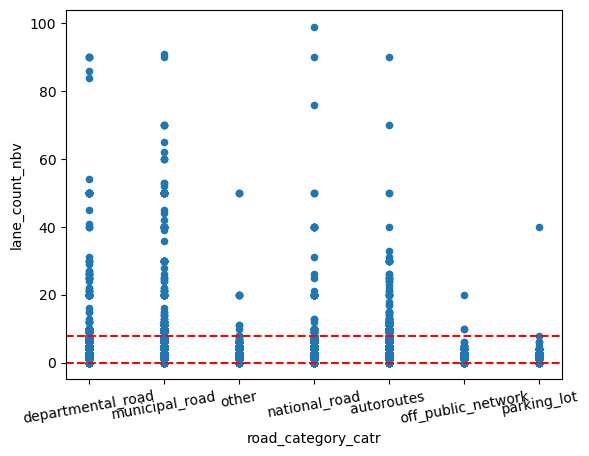

In [114]:
df_main.plot(kind='scatter', x='road_category_catr', y='lane_count_nbv')
plt.xticks(rotation=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=8, color='r', linestyle='--')
plt.show()

#AP: added horizontal lines for y=0 (min lanes) & y=8 (max lanes I'll allow)

No specific road type I can inveestigate for high or 0 lane count.

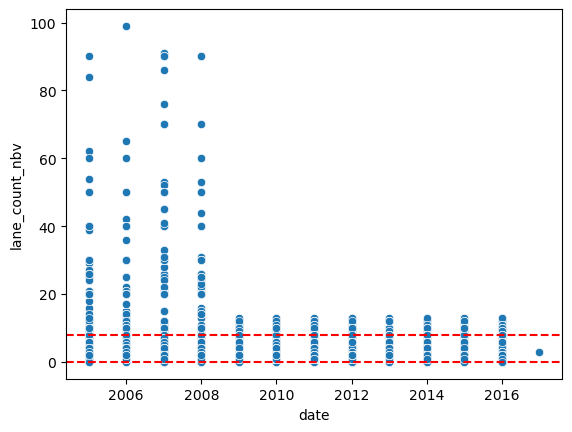

In [115]:
sns.scatterplot(data=df_main, x=df_main['date'].dt.year, y=df_main['lane_count_nbv'])
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=8, color='r', linestyle='--')
plt.show()

~2008 & ealier have the high values. Check to see the range of values for 2009 & later in order to figure out what I could replace the high values with~

Will be dropping rows with >8 lanes, accounts for <0.5% of total data

**AP: Seems that there's a 2017 year, probably just have to drop that single row**
#### Drop 2017 row

In [116]:
df_main[df_main['date'].dt.year == 2017].index

Index([19376], dtype='int64')

In [117]:
df_main.drop(df_main[df_main['date'].dt.year == 2017].index, inplace=True)

In [118]:
df_main[df_main['date'].dt.year == 2017].index

Index([], dtype='int64')

~AP: Starting at 2009, I want to see what the max value for lane count is~

#### Drop rows with >8 lanes

converting prior used cells to raw so they don't eecute and I can keep the code for later reference.|

~What kind of locations are these high number lanes?~

In [119]:
df_main.drop(df_main[df_main['lane_count_nbv'] > 8].index, axis=0, inplace=True)

In [120]:
df_main['lane_count_nbv'].value_counts(dropna=False).sort_index()

lane_count_nbv
0    102490
1    100385
2    459119
3     65954
4     75772
5      7771
6     13377
7       824
8      2050
Name: count, dtype: int64

AP: It is unclear (even from official documentation) whether lanes include ramps for highways. I am deciding to leave this as is.

#### Check zero lane roads

In [121]:
df_main[df_main['lane_count_nbv'] == 0].sample(5)

,acc_id,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,ped_present,hour,date,day_of_week,is_weekend,is_holiday
701580,200600042663,lum_full_day,False,x_intersection,normal,two_cars_side,departmental_road,two_way,0,no_reserved_lane,dish,straight,0,47,dry,none,road,0,13,2006-07-17 13:00:00,Monday,False,False
683382,200600024465,lum_full_day,False,out_of_intersection,normal,two_cars_side,departmental_road,seperated_carriageway,0,no_reserved_lane,hill_top,straight,100,0,dry,none,road,0,15,2006-05-21 15:00:00,Sunday,True,False
448504,200900023984,lum_full_day,False,out_of_intersection,normal,two_cars_rear,national_road,two_way,0,no_reserved_lane,dish,straight,90,0,dry,none,road,0,18,2009-08-07 18:00:00,Friday,False,False
81100,201500024352,lum_full_day,True,t_intersection,normal,other,municipal_road,other,0,no_reserved_lane,other,other,0,0,other,none,none,1,8,2015-05-06 08:00:00,Wednesday,False,False
25099,201600025881,lum_night_yes_light,True,out_of_intersection,normal,no_collision,other,other,0,no_reserved_lane,other,other,0,0,other,none,none,0,0,2016-07-10 00:00:00,Sunday,True,False


Plot value counts for cols corresponding to road type characteristics for lanes = 0

In [122]:
for col in ['built_up_agg', 'intersection_type_int', 'road_category_catr', 'road_type_circ', 'reserved_lane_type_vosp', 'central_sep_width_lartpc', 'road_width_larrout', 'infrastructure_infra']:
    print(df_main[df_main['lane_count_nbv'] == 0][col].value_counts().sort_values(ascending=False))
    print()

built_up_agg
True     60340
False    42150
Name: count, dtype: int64

intersection_type_int
out_of_intersection    80722
x_intersection          8019
t_intersection          5296
roundabout              3091
other                   2383
place                   1123
y_intersection           860
4+_intersection          845
level_crossing           151
Name: count, dtype: int64

road_category_catr
departmental_road     43909
municipal_road        39812
national_road          7940
other                  3705
autoroutes             3540
parking_lot            3093
off_public_network      491
Name: count, dtype: int64

road_type_circ
two_way                  66896
other                    16917
one_way                  10550
seperated_carriageway     7442
variable_assignment        685
Name: count, dtype: int64

reserved_lane_type_vosp
no_reserved_lane    98502
reserved_lane        1877
bike_path            1384
bike_parking          727
Name: count, dtype: int64

central_sep_width_lartpc
0

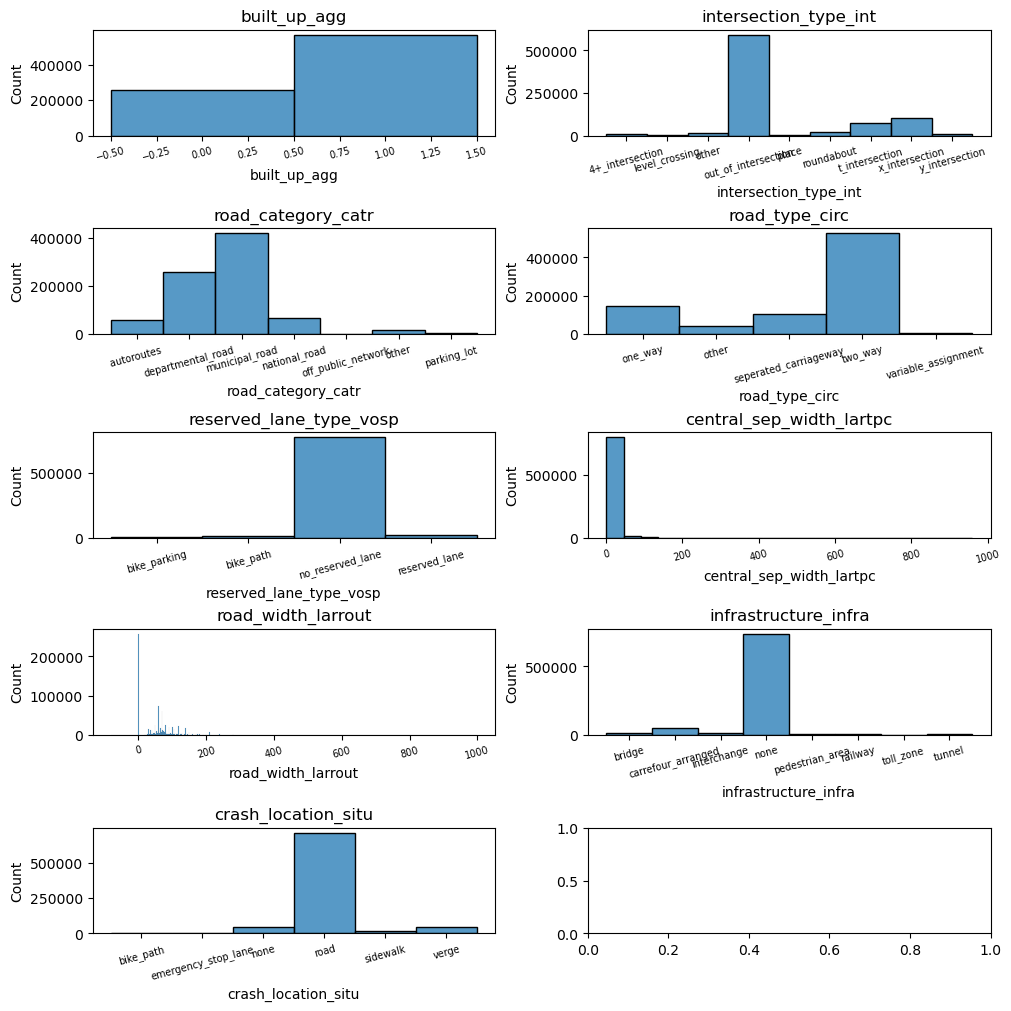

In [123]:
#warnings.filterwarnings('ignore')

columns_to_plot = ['built_up_agg', 'intersection_type_int', 'road_category_catr', 'road_type_circ', 'reserved_lane_type_vosp', 'central_sep_width_lartpc', 'road_width_larrout', 'infrastructure_infra', 'crash_location_situ']
n_cols = len(columns_to_plot)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10), layout="constrained")
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_main[col], ax=axes[i])
    axes[i].set_title(col)
    #axes[i].set_xlabel('')  # Remove x-axis labels for clarity if needed
    #xes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelrotation=15, labelsize=7)
#plt.tight_layout()
plt.show()

#warnings.resetwarnings()

Majority characteristics for 0-lane roads:
- In built up areas
    - (built_up_agg = True)
- Out of intersection
    - intersection_type_int = out_of_intersection
    - Implies either off a road or on stretch of road without intersection
- municipal road type & departmental road
    - road_category_catr = municipal_road OR departmental_road
    - essentially a county road
    - departmental road is essentially a toll-free highway
- Two way road
    - road_type_circ = two_way
- No reserved lane
    - reserved_lane_type_vosp = no_reserved_lane
- no central separator in road
    - central_sep_width_lartpc = 0
- Majority of roads have a width of 0
    - road_width_larrout = 0
    - Strongly suggests this feature as the next to investigate for consistent and expected values
- No infrastructure
    - infrastructure_infra = none

**Plan for replacing 0's :**

base it off of road_desc_cols (that I'll create below)

In [124]:
df_main[df_main['lane_count_nbv']==0]['lane_count_nbv'].value_counts(dropna=False).sort_index()

lane_count_nbv
0    102490
Name: count, dtype: int64

In [125]:
road_desc_cols = ['built_up_agg', 'intersection_type_int', 'road_category_catr', 'road_type_circ', 'reserved_lane_type_vosp', 'infrastructure_infra', 'crash_location_situ']

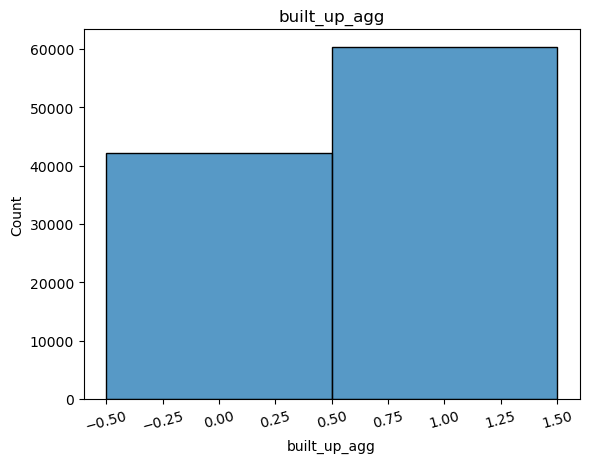

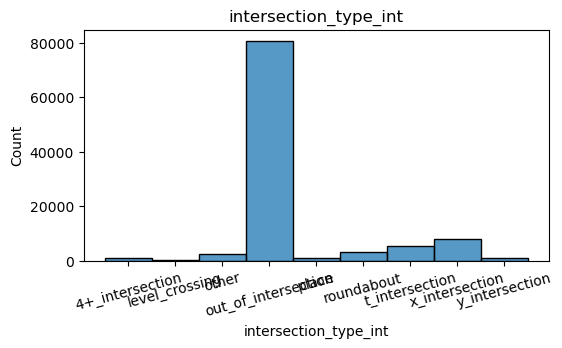

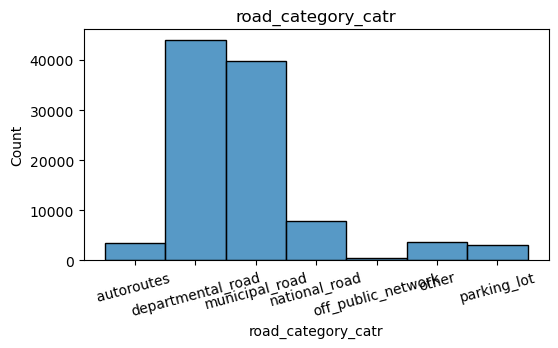

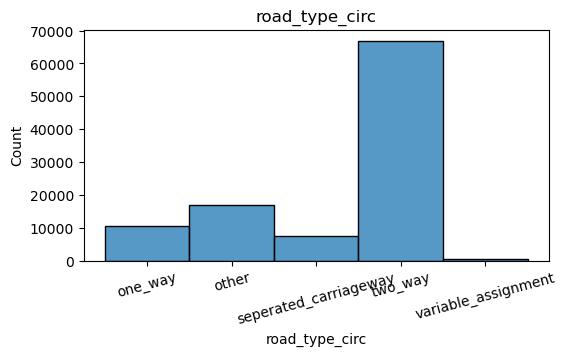

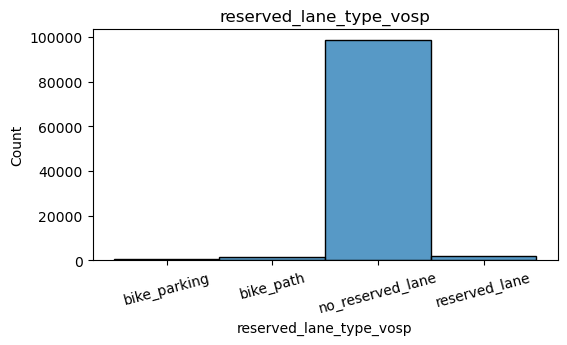

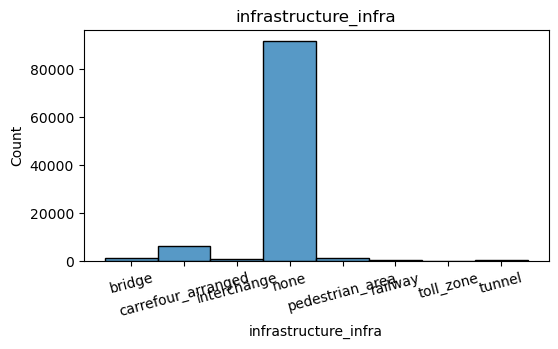

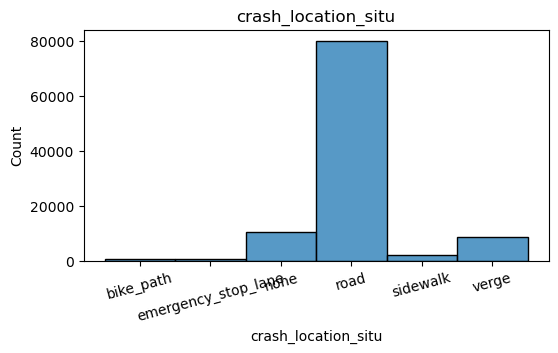

<Figure size 600x300 with 0 Axes>

In [126]:
warnings.filterwarnings('ignore')

for col in road_desc_cols:
    sns.histplot(data=df_main[df_main['lane_count_nbv']==0][[col]], x=df_main[df_main['lane_count_nbv']==0][col])
    plt.title(col)
    plt.xticks(rotation=15)
    plt.figure(figsize=(6,3))
    plt.show

warnings.resetwarnings()

In [127]:
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['road_type_circ'] == 'one_way') & 
    (df_main['road_category_catr'] == 'municipal_road'),
    'lane_count_nbv'
] = 1

In [128]:
df_main[df_main['lane_count_nbv']==0]['lane_count_nbv'].value_counts(dropna=False).sort_index()

lane_count_nbv
0    95424
Name: count, dtype: int64

In [129]:
df_main[df_main['lane_count_nbv']==0]['crash_location_situ'].value_counts()

crash_location_situ
road                   73817
none                    9948
verge                   8728
sidewalk                1996
bike_path                520
emergency_stop_lane      415
Name: count, dtype: int64

In [130]:
#duplicates check

df_main[df_main.duplicated(keep=False)].sort_values(by='date')

,acc_id,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,collision_type_col,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,central_sep_width_lartpc,road_width_larrout,surface_cond_surf,infrastructure_infra,crash_location_situ,ped_present,hour,date,day_of_week,is_weekend,is_holiday


In [131]:
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    ((df_main['road_category_catr'] == 'autoroutes') |
        (~df_main['road_category_catr'].isin(['other', 'parking_lot'])) |
        (df_main['road_type_circ']!='other') |
        (df_main['intersection_type_int']!='other') |
        (df_main['reserved_lane_type_vosp']!='no_reserved_lane') |
        (df_main['central_sep_width_lartpc'] != 0) |
        (df_main['road_slope_prof'] != 'other') |
        (df_main['road_curvature_plan'] != 'other') |
        (~df_main['infrastructure_infra'].isin(['none', 'pedestrian_area', 'railway'])) |
        (~df_main['crash_location_situ'].isin(['none', 'bike_path']))
    ),'lane_count_nbv'
    ] = 2

In [132]:
#Ensure 0 lanes for applicable situations (i.e. parking lots)
#make sure not to add 0 lane observations. Noticed that 
df_main.loc[(df_main['lane_count_nbv'] != 0) & 
    (df_main['road_category_catr'] == 'parking_lot'),
    'lane_count_nbv'
    ] = 0

In [133]:
df_main[df_main['lane_count_nbv']==0]['lane_count_nbv'].value_counts(dropna=False).sort_index()

lane_count_nbv
0    5416
Name: count, dtype: int64

Plot distributions of vals for 0 lanes:

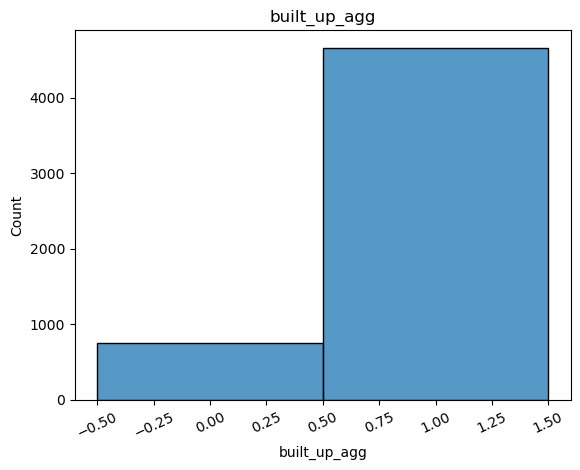

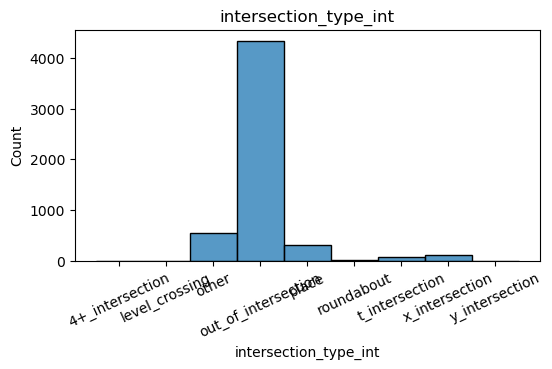

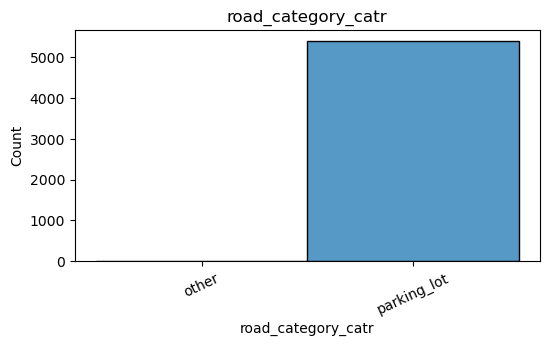

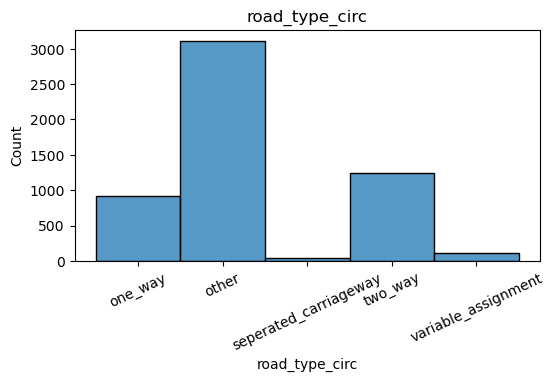

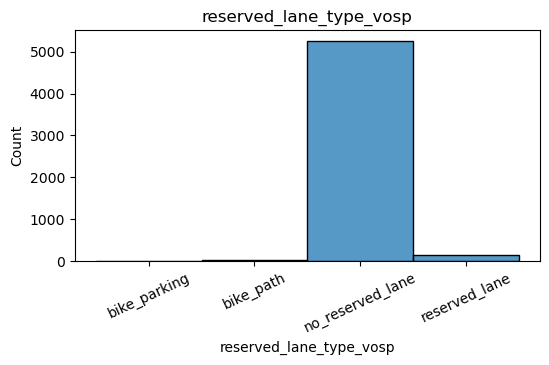

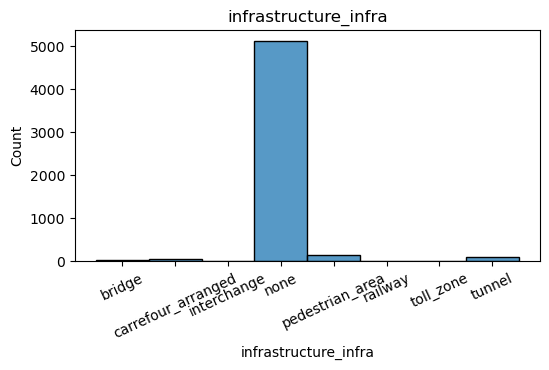

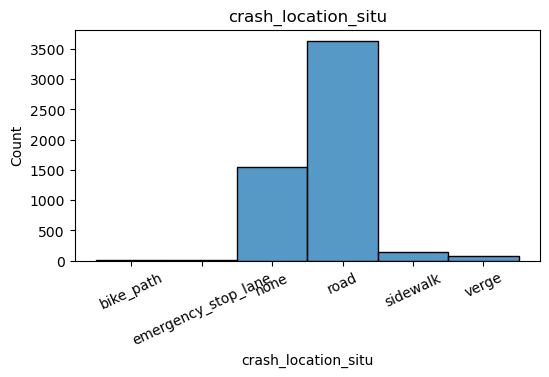

<Figure size 600x300 with 0 Axes>

In [134]:
warnings.filterwarnings('ignore')

for col in road_desc_cols:
    sns.histplot(data=df_main[df_main['lane_count_nbv']==0][[col]], x=df_main[df_main['lane_count_nbv']==0][col])
    plt.title(col)
    plt.xticks(rotation=25)
    plt.figure(figsize=(6,3))
    plt.show
    
warnings.resetwarnings()

Still some rows where lanes shouldn't be zero

In [135]:
for col in road_desc_cols:
    print(df_main[df_main['lane_count_nbv']==0][col].value_counts(dropna=False))
    print()

built_up_agg
True     4658
False     758
Name: count, dtype: int64

intersection_type_int
out_of_intersection    4338
other                   539
place                   308
x_intersection          122
t_intersection           79
roundabout               15
4+_intersection           5
level_crossing            5
y_intersection            5
Name: count, dtype: int64

road_category_catr
parking_lot           5406
other                   10
autoroutes               0
departmental_road        0
municipal_road           0
national_road            0
off_public_network       0
Name: count, dtype: int64

road_type_circ
other                    3110
two_way                  1237
one_way                   915
variable_assignment       118
seperated_carriageway      36
Name: count, dtype: int64

reserved_lane_type_vosp
no_reserved_lane    5249
reserved_lane        141
bike_path             20
bike_parking           6
Name: count, dtype: int64

infrastructure_infra
none                  5116
pedes

Where should not be 0 lanes: (& how many lanes can be reasonably & minimally expected)

- intersection_type_int
    - x_intersection
        - 2
    - t_intersection
        - 2
    - roundabout
        - 1
    - 4+_intersection
        - 2
    - y_intersection
        - 2
    - level_crossing
        - 1
- road_type_circ
    - two_way
        - 2
    - one_way
        - 1
    - variable_assignment
        - 1
    - seperated_carriageway
        - 2
- reserved_lane_type_vosp
    - reserved_lane
        - 1
- infrastructure_infra
    - tunnel
        - 1
    - carrefour_arranged
        - 2
    - bridge
        - 1
    - interchange
        - 2
    - toll_zone
        - 1
- crash_location_situ
    - road
        - 2 (reason: most roads are two lane (two-way))
    - verge
        - 1
    - emergency_stop_lane
        - 2

In [136]:
#changing one-by-one

#intersection_type_int 2 lanes
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['intersection_type_int'].isin(['x_intersection', 't_intersection', '4+_intersection', 'y_intersection']))
    , 'lane_count_nbv'] = 2

#intersection_type_int 1 lane
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['intersection_type_int'].isin(['roundabout', 'level_crossing']))
    , 'lane_count_nbv'] = 1

#road_type_circ 2 lanes
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['road_type_circ'].isin(['two_way', 'seperated_carriageway']))
    , 'lane_count_nbv'] = 2

#road_type_circ 1 lane
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['road_type_circ'].isin(['one_way', 'variable_assignment']))
    , 'lane_count_nbv'] = 1

#reserved_lane_type_vosp 1 lane
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['reserved_lane_type_vosp'].isin(['reserved_lane']))
    , 'lane_count_nbv'] = 1

#infrastructure_infra 2 lanes
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['infrastructure_infra'].isin(['carrefour_arrange', 'interchange']))
    , 'lane_count_nbv'] = 2

#infrastructure_infra 1 lane
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['infrastructure_infra'].isin(['tunnel', 'bridge', 'toll_zone']))
    , 'lane_count_nbv'] = 1

#crash_location_situ 2 lanes
df_main.loc[(df_main['lane_count_nbv'] == 0) &
    (df_main['crash_location_situ'].isin(['road', 'emergency_stop_lane']))
    , 'lane_count_nbv'] = 2

#crash_location_situ 1 lane
df_main.loc[(df_main['lane_count_nbv'] == 0) & 
    (df_main['crash_location_situ'].isin(['verge']))
    , 'lane_count_nbv'] = 2

In [137]:
for col in road_desc_cols:
    print(df_main[df_main['lane_count_nbv']==0][col].value_counts(dropna=False))
    print()

built_up_agg
True     1069
False     175
Name: count, dtype: int64

intersection_type_int
out_of_intersection    951
other                  162
place                  131
4+_intersection          0
level_crossing           0
roundabout               0
t_intersection           0
x_intersection           0
y_intersection           0
Name: count, dtype: int64

road_category_catr
parking_lot           1234
other                   10
autoroutes               0
departmental_road        0
municipal_road           0
national_road            0
off_public_network       0
Name: count, dtype: int64

road_type_circ
other                    1244
one_way                     0
seperated_carriageway       0
two_way                     0
variable_assignment         0
Name: count, dtype: int64

reserved_lane_type_vosp
no_reserved_lane    1238
bike_path              5
bike_parking           1
reserved_lane          0
Name: count, dtype: int64

infrastructure_infra
none                  1212
pedestrian_are

That puts the lane crisis to bed
___

### central_sep_width_lartpc check

The presence of a separator should be enough rather that the actual width in meters.

**Plan on adding a ~bool col of True/False~ int type (0/1) for presence of separator, then dropping this col**

central_sep_width_lartpc
0      697951
15      30482
10      17978
20      15457
30       7826
        ...  
487         1
159         1
322         1
187         1
625         1
Name: count, Length: 368, dtype: int64


<Axes: >

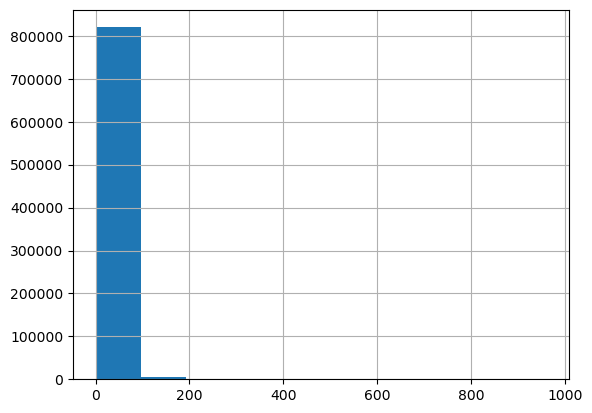

In [138]:
print(df_main['central_sep_width_lartpc'].value_counts())
df_main['central_sep_width_lartpc'].hist()

#### Create ~bool~ int (0/1) col for sep_present

In [139]:
df_main['sep_present'] = df_main['central_sep_width_lartpc'] == 0

In [140]:
print(df_main[['sep_present']].dtypes)
df_main[['sep_present']].head(8)

sep_present    bool
dtype: object


,sep_present
0,True
1,True
2,True
3,True
4,True
5,True
6,False
7,True


In [141]:
df_main['sep_present'] = df_main['sep_present'].astype('int')

In [142]:
print(df_main[['sep_present']].dtypes)
df_main[['sep_present']].head(8)

sep_present    int32
dtype: object


,sep_present
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,1


#### Drop central_sep_width_lartpc col

In [143]:
df_main.drop('central_sep_width_lartpc', axis=1, inplace=True)

In [144]:
'central_sep_width_lartpc' in df_main.columns

False

In [145]:
df_main['sep_present'].value_counts()

sep_present
1    697951
0    129791
Name: count, dtype: int64

### road_width_larrout check

road_width_larrout
-81          1
 0      257639
 1         111
 2          12
 3          30
         ...  
 980         4
 985         1
 990        12
 995         1
 999         3
Name: count, Length: 529, dtype: int64

nunique: 529


<Axes: >

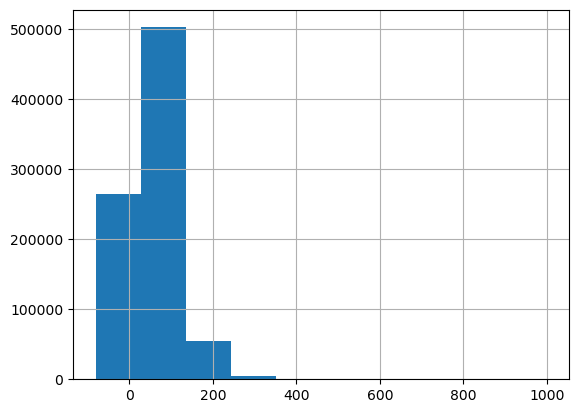

In [146]:
print(df_main['road_width_larrout'].value_counts().sort_index())
print('\nnunique:',df_main['road_width_larrout'].nunique())
df_main['road_width_larrout'].hist()

In [147]:
len(df_main[df_main['road_width_larrout'] > 0])

570102

##### **Dropping col**

Dropping based on usefullness of knowing width of the road for purpose of knowing where to send personnel & resources. The width of the road is not normally easily known, especially ot readily available during emergency situtations.

In [148]:
df_main.drop('road_width_larrout', axis=1, inplace=True)

In [149]:
'road_width_larrout' in df_main.columns

False

## Drop more columns

- acc_id
- collision_type_col
    - would be useful if predicting severity of crash. Currently just interested in if specific location or conditions would have high crash probability
- crash_location_situ
    - post-crash info. would be potentially useful if predicting severity of crash.

In [150]:
df_main.drop(columns=['acc_id', 'collision_type_col', 'crash_location_situ'], inplace=True)

In [151]:
for col in ['acc_id', 'collision_type_col', 'crash_location_situ']:
    print(f'{col} col in df_main: {col in df_main.columns}')

acc_id col in df_main: False
collision_type_col col in df_main: False
crash_location_situ col in df_main: False


In [152]:
##reset index, mostly as a just-in-case. Looks fine from doing df.head(), just want to be sure
df_main.reset_index(drop=True, inplace=True)

In [153]:
df_main.tail()

,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,surface_cond_surf,infrastructure_infra,ped_present,hour,date,day_of_week,is_weekend,is_holiday,sep_present
827737,lum_night_yes_light,True,x_intersection,normal,municipal_road,two_way,3,no_reserved_lane,dish,straight,dry,none,0,21,2005-12-21 21:00:00,Wednesday,False,False,1
827738,lum_full_day,True,out_of_intersection,normal,municipal_road,two_way,2,no_reserved_lane,dish,curve_left,dry,none,0,10,2005-12-23 10:00:00,Friday,False,False,1
827739,lum_full_day,True,x_intersection,normal,municipal_road,one_way,2,no_reserved_lane,dish,straight,dry,none,0,17,2005-12-26 17:00:00,Monday,False,False,1
827740,lum_full_day,True,t_intersection,rain_light,municipal_road,two_way,2,no_reserved_lane,dish,straight,dry,none,0,15,2005-12-27 15:00:00,Tuesday,False,False,1
827741,lum_night_yes_light,True,out_of_intersection,rain_light,national_road,seperated_carriageway,2,no_reserved_lane,dish,curve_left,wet,none,0,21,2005-12-31 21:00:00,Saturday,True,False,0


## convert to int type

Bools &

['hour', sep_present, & lane_count_nbv] from int32 to int64 just for consistency

In [154]:
df_main.dtypes

luminosity_lum                   category
built_up_agg                     category
intersection_type_int            category
weather_atm                      category
road_category_catr               category
road_type_circ                   category
lane_count_nbv                      int32
reserved_lane_type_vosp          category
road_slope_prof                  category
road_curvature_plan              category
surface_cond_surf                category
infrastructure_infra             category
ped_present                         int64
hour                                int32
date                       datetime64[ns]
day_of_week                      category
is_weekend                           bool
is_holiday                           bool
sep_present                         int32
dtype: object

In [155]:
#'hour', 'sep_present', & 'lane_count_nbv' cols

df_main[['hour', 'sep_present', 'lane_count_nbv']] = df_main[['hour', 'sep_present', 'lane_count_nbv']].astype('int64')
print(df_main[['hour', 'sep_present', 'lane_count_nbv']].dtypes)

hour              int64
sep_present       int64
lane_count_nbv    int64
dtype: object


In [156]:
#is_weekend & is_holiday cols

df_main[['is_weekend', 'is_holiday']] = df_main[['is_weekend', 'is_holiday']].astype('int64')
print(df_main[['is_weekend', 'is_holiday']].dtypes)

is_weekend    int64
is_holiday    int64
dtype: object


## A check before doing Full EDA

In [157]:
df_main.head()

,luminosity_lum,built_up_agg,intersection_type_int,weather_atm,road_category_catr,road_type_circ,lane_count_nbv,reserved_lane_type_vosp,road_slope_prof,road_curvature_plan,surface_cond_surf,infrastructure_infra,ped_present,hour,date,day_of_week,is_weekend,is_holiday,sep_present
0,lum_full_day,True,out_of_intersection,cloudy,departmental_road,two_way,2,no_reserved_lane,dish,curve_right,dry,none,0,15,2016-02-01 15:00:00,Monday,0,0,1
1,lum_full_day,True,roundabout,normal,departmental_road,one_way,2,no_reserved_lane,dish,curve_left,dry,none,0,18,2016-03-16 18:00:00,Wednesday,0,0,1
2,lum_full_day,False,out_of_intersection,normal,departmental_road,two_way,2,no_reserved_lane,dish,curve_right,wet,none,1,19,2016-07-13 19:00:00,Wednesday,0,0,1
3,lum_twighlight,True,out_of_intersection,dazzling,municipal_road,two_way,2,no_reserved_lane,dish,straight,dry,none,0,20,2016-08-15 20:00:00,Monday,0,0,1
4,lum_full_day,True,t_intersection,normal,municipal_road,other,2,no_reserved_lane,other,straight,dry,none,0,11,2016-12-23 11:00:00,Friday,0,0,1


In [158]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   luminosity_lum           827742 non-null  category      
 1   built_up_agg             827742 non-null  category      
 2   intersection_type_int    827742 non-null  category      
 3   weather_atm              827742 non-null  category      
 4   road_category_catr       827742 non-null  category      
 5   road_type_circ           827742 non-null  category      
 6   lane_count_nbv           827742 non-null  int64         
 7   reserved_lane_type_vosp  827742 non-null  category      
 8   road_slope_prof          827742 non-null  category      
 9   road_curvature_plan      827742 non-null  category      
 10  surface_cond_surf        827742 non-null  category      
 11  infrastructure_infra     827742 non-null  category      
 12  ped_present     

## Reorder cols to group by general theme
Easier for me to mentally parse.

Themes such as "road description", "driving conditions", "weather condition", "temporal description"

In [159]:
df_main = df_main[[
    #road desc.
    'road_category_catr', 'road_type_circ', 'intersection_type_int', 'lane_count_nbv', 'reserved_lane_type_vosp', 'sep_present', 'built_up_agg', 'road_slope_prof', 'road_curvature_plan', 'infrastructure_infra',
    #driving cond.
    'surface_cond_surf', 'ped_present',
    #weather
    'weather_atm', 'luminosity_lum',
    #Temporal
    'date', 'hour', 'day_of_week', 'is_weekend', 'is_holiday']]

#make lists of col names for each group (less typing for future me)
desc_road = ['road_category_catr', 'road_type_circ', 'intersection_type_int', 'lane_count_nbv', 'reserved_lane_type_vosp', 'sep_present', 'built_up_agg', 'road_slope_prof', 'road_curvature_plan', 'infrastructure_infra']
desc_driving = ['surface_cond_surf', 'ped_present']
desc_weather = ['weather_atm', 'luminosity_lum']
desc_time = ['date', 'hour', 'day_of_week', 'is_weekend', 'is_holiday']

In [160]:
#make sure I didn't miss any
print(len(desc_driving + desc_road + desc_time + desc_weather))
print(len(df_main.columns))

19
19


In [161]:
df_main.head(2)

,road_category_catr,road_type_circ,intersection_type_int,lane_count_nbv,reserved_lane_type_vosp,sep_present,built_up_agg,road_slope_prof,road_curvature_plan,infrastructure_infra,surface_cond_surf,ped_present,weather_atm,luminosity_lum,date,hour,day_of_week,is_weekend,is_holiday
0,departmental_road,two_way,out_of_intersection,2,no_reserved_lane,1,True,dish,curve_right,none,dry,0,cloudy,lum_full_day,2016-02-01 15:00:00,15,Monday,0,0
1,departmental_road,one_way,roundabout,2,no_reserved_lane,1,True,dish,curve_left,none,dry,0,normal,lum_full_day,2016-03-16 18:00:00,18,Wednesday,0,0


# EDA

Hypotheses:
- majority of crashes occur for:
    - conditions:
        - no light
        - bad weather (heavy rain, storm)
        - common slippery surface conditions (ice, snowy, wet)
    - road types:
        - built-up
        - out_of_intersection
        - Municipal road type
        - two-way road
    - Time conditions
        - weekends & holidays

In [162]:
df_main.head()

,road_category_catr,road_type_circ,intersection_type_int,lane_count_nbv,reserved_lane_type_vosp,sep_present,built_up_agg,road_slope_prof,road_curvature_plan,infrastructure_infra,surface_cond_surf,ped_present,weather_atm,luminosity_lum,date,hour,day_of_week,is_weekend,is_holiday
0,departmental_road,two_way,out_of_intersection,2,no_reserved_lane,1,True,dish,curve_right,none,dry,0,cloudy,lum_full_day,2016-02-01 15:00:00,15,Monday,0,0
1,departmental_road,one_way,roundabout,2,no_reserved_lane,1,True,dish,curve_left,none,dry,0,normal,lum_full_day,2016-03-16 18:00:00,18,Wednesday,0,0
2,departmental_road,two_way,out_of_intersection,2,no_reserved_lane,1,False,dish,curve_right,none,wet,1,normal,lum_full_day,2016-07-13 19:00:00,19,Wednesday,0,0
3,municipal_road,two_way,out_of_intersection,2,no_reserved_lane,1,True,dish,straight,none,dry,0,dazzling,lum_twighlight,2016-08-15 20:00:00,20,Monday,0,0
4,municipal_road,other,t_intersection,2,no_reserved_lane,1,True,other,straight,none,dry,0,normal,lum_full_day,2016-12-23 11:00:00,11,Friday,0,0


In [163]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   road_category_catr       827742 non-null  category      
 1   road_type_circ           827742 non-null  category      
 2   intersection_type_int    827742 non-null  category      
 3   lane_count_nbv           827742 non-null  int64         
 4   reserved_lane_type_vosp  827742 non-null  category      
 5   sep_present              827742 non-null  int64         
 6   built_up_agg             827742 non-null  category      
 7   road_slope_prof          827742 non-null  category      
 8   road_curvature_plan      827742 non-null  category      
 9   infrastructure_infra     827742 non-null  category      
 10  surface_cond_surf        827742 non-null  category      
 11  ped_present              827742 non-null  int64         
 12  weather_atm     

## Summary Stats

In [164]:
#road description
df_main[desc_road].describe(include='all')

,road_category_catr,road_type_circ,intersection_type_int,lane_count_nbv,reserved_lane_type_vosp,sep_present,built_up_agg,road_slope_prof,road_curvature_plan,infrastructure_infra
count,827742,827742,827742,827742.000000,827742,827742.000000,827742,827742,827742,827742
unique,7,5,9,NaN,4,NaN,2,5,5,8
top,municipal_road,two_way,out_of_intersection,NaN,no_reserved_lane,NaN,True,dish,straight,none
freq,420237,526275,592311,NaN,776833,NaN,568648,625717,631023,738651
mean,NaN,NaN,NaN,2.242641,NaN,0.843199,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,0.989718,NaN,0.363614,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,NaN,NaN


In [165]:
#desc_driving
df_main[desc_driving].describe(include='all')

,surface_cond_surf,ped_present
count,827742,827742.000000
unique,9,NaN
top,dry,NaN
freq,643853,NaN
mean,NaN,0.185175
std,NaN,0.423778
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


In [166]:
#desc_weather
df_main[desc_weather].describe(include='all')

,weather_atm,luminosity_lum
count,827742,827742
unique,9,4
top,normal,lum_full_day
freq,671029,568399


In [167]:
#desc_time
df_main[desc_time].describe(include='all')

,date,hour,day_of_week,is_weekend,is_holiday
count,827742,827742.000000,827742,827742.000000,827742.000000
unique,NaN,NaN,7,NaN,NaN
top,NaN,NaN,Friday,NaN,NaN
freq,NaN,NaN,137824,NaN,NaN
mean,2010-06-26 12:03:32.935915008,13.743819,NaN,0.256157,0.000830
min,2005-01-01 00:00:00,0.000000,NaN,0.000000,0.000000
25%,2007-06-17 16:00:00,10.000000,NaN,0.000000,0.000000
50%,2010-03-11 16:00:00,15.000000,NaN,0.000000,0.000000
75%,2013-06-07 02:00:00,18.000000,NaN,1.000000,0.000000
max,2016-12-31 23:00:00,23.000000,NaN,1.000000,1.000000


## Single Feature Distributions

road description

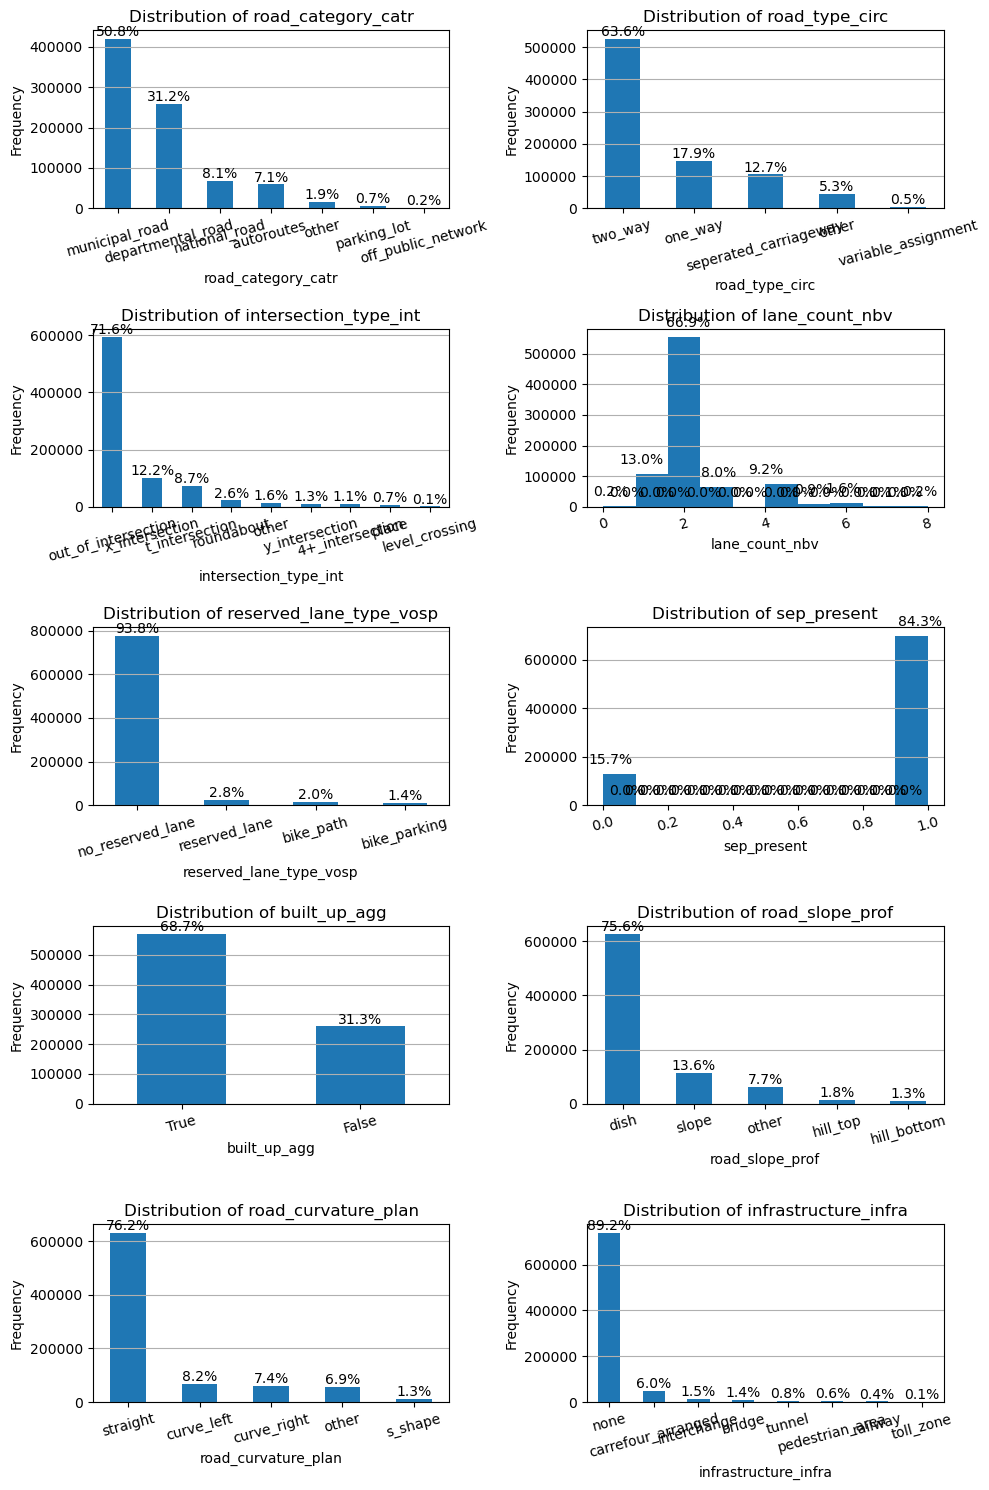

In [168]:
warnings.filterwarnings('ignore')

#added percentage annotations
fig, axes = plt.subplots(5, 2, layout='tight', figsize=(10, 15))
axes = axes.flatten()

for ax, col in zip(axes, desc_road):
    if df_main[col].dtype == 'category' or df_main[col].dtype == 'bool':
        df_main[col].value_counts().plot(kind='bar', ax=ax, include_bool=True)

        total = df_main[col].count()
        for p in ax.patches:
            height = p.get_height()
            percent = 100 * height / total
            ax.annotate(f'{percent:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='center', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    else:
        df_main[col].plot(kind='hist', ax=ax)
            #note: sns.histplot was having 4 lanes as highest proportion, switched to pandas/matplotlib syntax
        counts, bins = np.histogram(df_main[col], bins='auto')
        total = counts.sum()
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        for center, count in zip(bin_centers, counts):
            percent = 100 * count / total
            ax.annotate(f'{percent:.1f}%', 
                        (center, count), 
                        ha='center', va='bottom', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.yaxis.grid(True)

plt.show()

warnings.resetwarnings()

**Observations:**

- municipal & departmental roads have majority of crashes
- two way roads
- out of intersection
    - can imply off road as well as parts of road between intersections
- 2 lane roads
- no reserved lane
    - follows that municipal roads don't usually have a reserved lane
- separator is commonly present (separating opposite traffic direction)
- Commonly in built up areas
    - ex. within a city rather than in the country-side
- dish road slope
    - i.e. a valley between 2 hills
- straight roads are where majority of crashes occur
    - Makes sense based on assumption that majority of road length is straight (would require deeper research to verify)
    - Previously thought that 's_shape' would have higher proportion
- no infrastructure present for most crashes

desc_driving

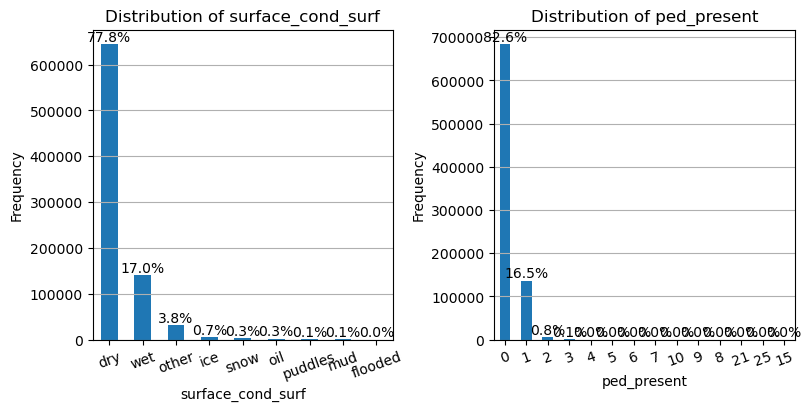

In [169]:
warnings.filterwarnings('ignore')

#added percentage annotations
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained', figsize=(8, 4))

for ax, col in zip(axes, desc_driving):
    df_main[col].value_counts().plot(kind='bar', ax=ax, include_bool=True)

    total = df_main[col].count()
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.annotate(f'{percent:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    ax.yaxis.grid(True)

plt.show()

warnings.resetwarnings()

**Observations:**

- Dry roads are most common with wet road surfaces being a distant second ('other' being even more distant third)
    - Makes sense as dry conditions are extremely common compared to any other
- Pedestrians are not commonly present in a crash

desc_weather

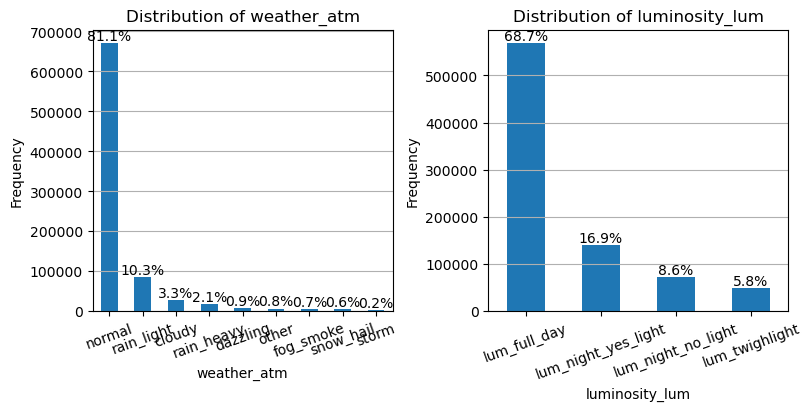

In [170]:
warnings.filterwarnings('ignore')

#added percentage annotations
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained', figsize=(8, 4))

for ax, col in zip(axes, desc_weather):
    df_main[col].value_counts().plot(kind='bar', ax=ax, include_bool=True)

    total = df_main[col].count()
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.annotate(f'{percent:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    ax.yaxis.grid(True)

plt.show()

warnings.resetwarnings()

**Observations:**

- Majority is 'normal' weather
    - implying reasonable sunshine for visibility, sparse cloud cover, and no percipitation
- light rain is distant second weather condition for crashes
- full daylight is present for majority of crashes
    - Indicates that crash occured during day time
        - (time-series plots below show most crashes occur between 8am-7pm) (sunset time varies through the year but avg's after 7pm (https://sunrise-sunset.org/france))
    - Makes sense as 'normal' weather is most common
- night time with artificial lighting is distantly second most common for crashes
    - Original expectation was that less lighting (lum_night_no_light or lum_twighlight) would be in greater proportion

desc_time

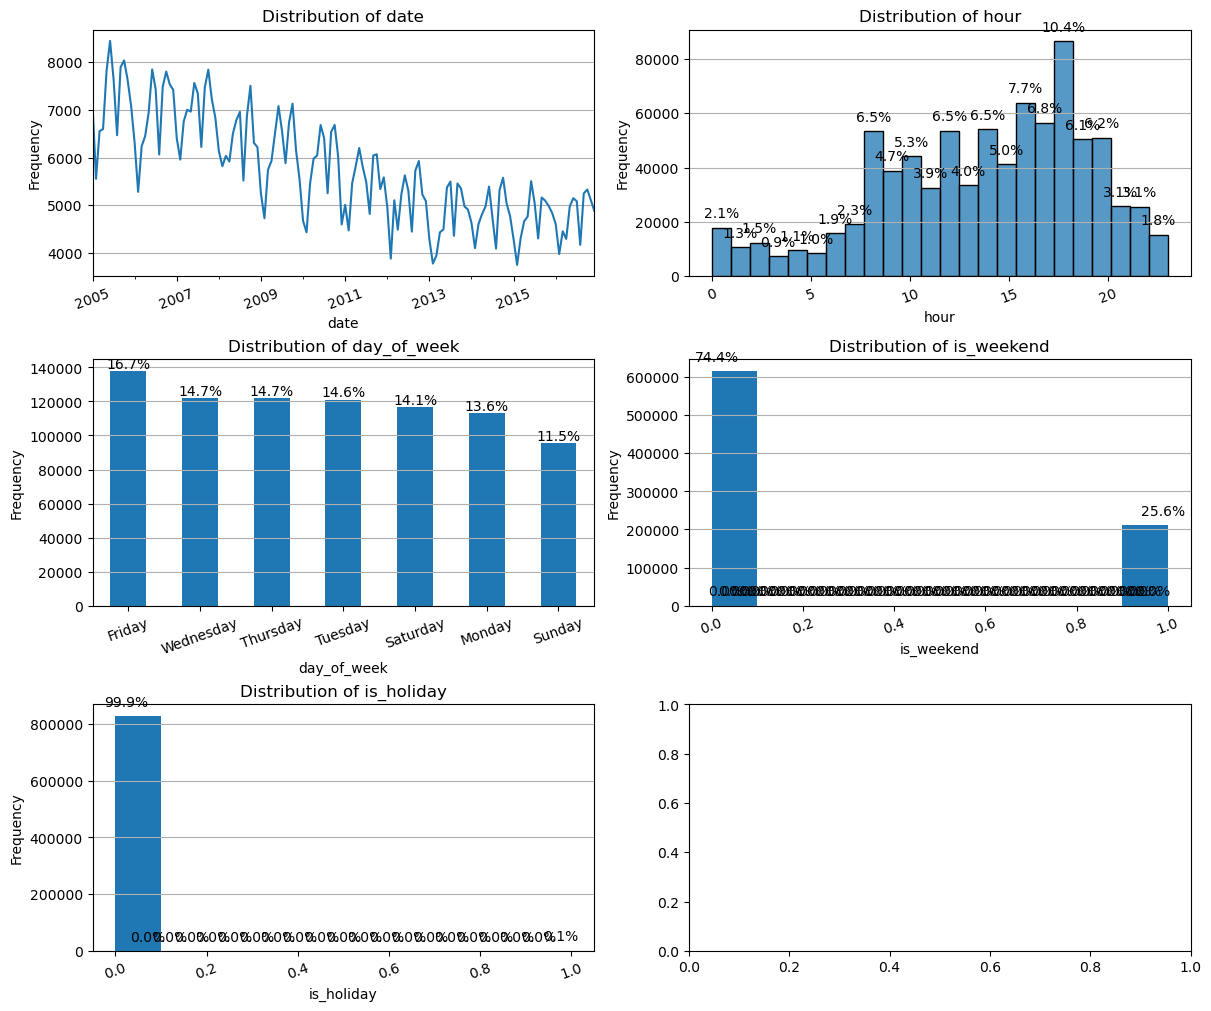

In [171]:
warnings.filterwarnings('ignore')

#added percentage annotations
fig, axes = plt.subplots(nrows=3, ncols=2, layout='constrained', figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, desc_time):
    if col == 'date':
        monthly_counts = df_main.set_index('date')
        monthly_counts = monthly_counts.resample('M').size()
        monthly_counts.plot(ax=ax)
        #df_main.set_index('date')[col].resample('M').size().plot(ax=ax)
        ax.set_title(f'Monthly Trend of Records')
        ax.set_xlabel('Date')
        ax.set_ylabel('Count')

    elif col == 'hour':
        sns.histplot(df_main[col], bins=24, ax=ax)

        counts, bins = np.histogram(df_main[col], bins=24)
        total = counts.sum()
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        for center, count in zip(bin_centers, counts):
            percent = 100 * count / total
            ax.annotate(f'{percent:.1f}%', 
                        (center, count), 
                        ha='center', va='bottom', 
                        xytext=(0, 5), 
                        textcoords='offset points')


    elif df_main[col].dtype == 'category' or df_main[col].dtype == 'bool':
        df_main[col].value_counts().plot(kind='bar', ax=ax, include_bool=True)

        total = df_main[col].count()
        for p in ax.patches:
            height = p.get_height()
            percent = 100 * height / total
            ax.annotate(f'{percent:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='center', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    else:
        df_main[col].plot(kind='hist', ax=ax)

        counts, bins = np.histogram(df_main[col], bins='auto')
        total = counts.sum()
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        for center, count in zip(bin_centers, counts):
            percent = 100 * count / total
            ax.annotate(f'{percent:.1f}%', 
                        (center, count), 
                        ha='center', va='bottom', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    ax.yaxis.grid(True)

plt.show()

warnings.resetwarnings()

**Observations:**

- (Time-series check) Crashes seem to be declining in a linear fashion over the years
- Time frame for elevated crashes is 8am - 7pm
    - Peak at 6pm
    - (sunset time varies through the year but avg's after 7pm (https://sunrise-sunset.org/france))
- Friday has the most crashes
    - Sunday has least amount of crashes
    - rest of days are near even in proportion (monday is slightly less but not by a lot)
- Not usually a weekend for crashes
    - Makes sense as friday is most common crash day
    - And that weekdays are more common than weekends
- Super majority of crashes on non-holidays
    - Makes sense as holidays are not common (especially with only looking at 11 days out of the 365 day year)

## Bivariate Analysis

### Categorical-Categorical Feature Relationships

#### Chi-Square Test for Independence
**Outputing only p-values != 0** since it'd be quite a lot of output otherwise

If p-value = 0 then that denotes statistical significance of the difference of actual & expected, strongly suggesting a relationship between the two features

___
desc_road

In [172]:
print(df_main[desc_road].dtypes)

road_category_catr         category
road_type_circ             category
intersection_type_int      category
lane_count_nbv                int64
reserved_lane_type_vosp    category
sep_present                   int64
built_up_agg               category
road_slope_prof            category
road_curvature_plan        category
infrastructure_infra       category
dtype: object


In [173]:
for col1 in desc_road:
    for col2 in desc_road:
        if (df_main[col].dtype == 'category') | (df_main[col].dtype == 'int64'):
            if col1 != col2:
                contingency_table = pd.crosstab(df_main[col1], df_main[col2])
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                if p != 0 :
                    print(f'Chi-Square Test for {col1} vs {col2}: Chi2 = {chi2:.2f}, p-value = {p}')

Chi-Square Test for reserved_lane_type_vosp vs sep_present: Chi2 = 617.32, p-value = 1.7755592544441207e-133
Chi-Square Test for sep_present vs reserved_lane_type_vosp: Chi2 = 617.32, p-value = 1.7755592544441207e-133
Chi-Square Test for sep_present vs road_slope_prof: Chi2 = 1147.51, p-value = 3.808417901207081e-247
Chi-Square Test for road_slope_prof vs sep_present: Chi2 = 1147.51, p-value = 3.8084179012075134e-247


Output has p-values at essentially 0, much less than 0.05 for the commonly used significance level.

**Each feature in listed in desc_road has a statistically significant relationship to each other**

___
desc_driving

In [174]:
print(df_main[desc_driving].dtypes)

surface_cond_surf    category
ped_present             int64
dtype: object


In [175]:
for col1 in desc_driving:
    for col2 in desc_driving:
        if (df_main[col].dtype == 'category') | (df_main[col].dtype == 'int64'):
            if col1 != col2:
                contingency_table = pd.crosstab(df_main[col1], df_main[col2])
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                if p != 0 :
                    print(f'Chi-Square Test for {col1} vs {col2}: Chi2 = {chi2:.2f}, p-value = {p}')

Chi-Square Test for surface_cond_surf vs ped_present: Chi2 = 961.15, p-value = 8.263706118812724e-139
Chi-Square Test for ped_present vs surface_cond_surf: Chi2 = 961.15, p-value = 8.263706118814138e-139


Output has p-values at essentially 0, much less than 0.05 for the commonly used significance level.

**Each feature in listed in desc_driving has a statistically significant relationship to each other**

___
desc_weather

In [176]:
print(df_main[desc_weather].dtypes)

weather_atm       category
luminosity_lum    category
dtype: object


In [177]:
for col1 in desc_weather:
    for col2 in desc_weather:
        if (df_main[col].dtype == 'category'):
            if col1 != col2:
                contingency_table = pd.crosstab(df_main[col1], df_main[col2])
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                if p != 0 :
                    print(f'Chi-Square Test for {col1} vs {col2}: Chi2 = {chi2:.2f}, p-value = {p}')

No output with p-values != 0.

**Each feature in listed in desc_weather has a statistically significant relationship to each other**

___
desc_time

In [178]:
print(df_main[desc_time].dtypes)

date           datetime64[ns]
hour                    int64
day_of_week          category
is_weekend              int64
is_holiday              int64
dtype: object


In [179]:
for col1 in desc_time:
    for col2 in desc_time:
        if (df_main[col].dtype == 'category') | (df_main[col].dtype == 'int64'):
            if col1 != col2:
                contingency_table = pd.crosstab(df_main[col1], df_main[col2])
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                if p != 0 :
                    print(f'Chi-Square Test for {col1} vs {col2}: Chi2 = {chi2:.2f}, p-value = {p}')

Chi-Square Test for day_of_week vs is_holiday: Chi2 = 113.18, p-value = 4.405546995397704e-22
Chi-Square Test for is_weekend vs is_holiday: Chi2 = 0.00, p-value = 1.0
Chi-Square Test for is_holiday vs day_of_week: Chi2 = 113.18, p-value = 4.405546995397704e-22
Chi-Square Test for is_holiday vs is_weekend: Chi2 = 0.00, p-value = 1.0


No relationship:
- is_weekend & is_holiday

All other features have a relationship

### Categorical - Numerical Relationships

Essentially a check that 0 lane roads were handled correctly. Since lanes col is only actual numerical col (hour is int type but is essentially ordered categorical)

Converting cells to raw to not execute the code.

___
desc_road

In [180]:
print(desc_road)

['road_category_catr', 'road_type_circ', 'intersection_type_int', 'lane_count_nbv', 'reserved_lane_type_vosp', 'sep_present', 'built_up_agg', 'road_slope_prof', 'road_curvature_plan', 'infrastructure_infra']


___
desc_driving

In [181]:
print(desc_driving)

['surface_cond_surf', 'ped_present']


___
desc_weather

In [182]:
print(desc_weather)

['weather_atm', 'luminosity_lum']


___
desc_time

In [183]:
print(desc_time)

['date', 'hour', 'day_of_week', 'is_weekend', 'is_holiday']


## Observations Summary

- Crashes seem to be declining in a linear fashion over the years

Road Characteristics:
- Municipal (local) roads account for about 50% of crashes
    - highways (departmental, national, autoroutes) account for about 47% of crashes
- ~64% of crashes occur on two-way roads
- ~72% of crashes occur outside any intersection
    - Proving a starting hypothesis wrong
- ~84% of crashes have a separator present (separating bi-directional roads)
- ~69% occur in built-up areas (ex. within towns or cities)
- ~76% occur on dish shaped stretches of road
    - low point between two higher points (ex. \_/)
- ~76% occur on straight strethces of road
- ~89% occur away from road infrastructure (such as toll zones or bridges)

Driving Conditions:
- ~78% occur with a dry road
- ~83% occur with no pedestrians present

Weather Conditions:
- ~81% of crashes occur during normal weather (light out, sparse clouds, no precipitation)
    - ~10% occur during rain
- ~69% occur during the day
    - ~17% occur at night with artificial lighting
    - Disproves starting hypothesis that more crashes occur with minimized light

Time Conditions:
- Hour of day range for elevated crashes:
    - 8am-7pm
    - peak at 6pm (10.4%)
- Friday is most common day of week at 16.7%
    - Other days (except Sunday) hover around 14%
    - Sunday about 12%
- Crashes usually occur on weekdays
- Almost no crashes occur on a holiday

Bivariate Relationships:
- All features related to each other within themed groups except:
    - weekends and holidays
- Makes sense as presence of road characteristics are usually dependent on others

# Next Steps

- Encode categorical features with pd.get_dummies in next notebook. (one-hot)
- Split off 'date' col when analyzing actual locations
    - Use it for doing time-series analysis
- Create col ('loc_num') to categorize each possible combo of all features
    - numbered 1 through n for each unique feature combo
- Use loc_num to synthetically create non-crash observations
    - Allows for model to be used for supervised classification of Yes/No for a crash
    - Need to label True/False for crash too
- Start off the modeling phase with logistic regression
    - Can get coeff's for each feature for how much it effects True/False for crash
- Make neural network model for predicting crash
- Time-series analysis (?)

# Export df as csv
convert back to code cell if needed

# Pre-Processing

Planned Steps: (tentative plan)

- Create dummy or indicator features for categorical variables
    - Plan on pd.get_dummies to one-hot encode
- Create 'crash' col
    - if crash then 1, if not crash then 2
    - As df is currently, every row gets crash=1
- Artificially create crash=0 observations
    - Will need to create a matrix of all the possible combos of features then assign crash=0 to those combos not found in the starting df
- ~Standardize the magnitude of numeric features~
    - No numeric/continuous features in data (all categorical in nature)
- Split into testing and training datasets

In [184]:
print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   road_category_catr       827742 non-null  category      
 1   road_type_circ           827742 non-null  category      
 2   intersection_type_int    827742 non-null  category      
 3   lane_count_nbv           827742 non-null  int64         
 4   reserved_lane_type_vosp  827742 non-null  category      
 5   sep_present              827742 non-null  int64         
 6   built_up_agg             827742 non-null  category      
 7   road_slope_prof          827742 non-null  category      
 8   road_curvature_plan      827742 non-null  category      
 9   infrastructure_infra     827742 non-null  category      
 10  surface_cond_surf        827742 non-null  category      
 11  ped_present              827742 non-null  int64         
 12  weather_atm     

,road_category_catr,road_type_circ,intersection_type_int,lane_count_nbv,reserved_lane_type_vosp,sep_present,built_up_agg,road_slope_prof,road_curvature_plan,infrastructure_infra,surface_cond_surf,ped_present,weather_atm,luminosity_lum,date,hour,day_of_week,is_weekend,is_holiday
0,departmental_road,two_way,out_of_intersection,2,no_reserved_lane,1,True,dish,curve_right,none,dry,0,cloudy,lum_full_day,2016-02-01 15:00:00,15,Monday,0,0
1,departmental_road,one_way,roundabout,2,no_reserved_lane,1,True,dish,curve_left,none,dry,0,normal,lum_full_day,2016-03-16 18:00:00,18,Wednesday,0,0
2,departmental_road,two_way,out_of_intersection,2,no_reserved_lane,1,False,dish,curve_right,none,wet,1,normal,lum_full_day,2016-07-13 19:00:00,19,Wednesday,0,0
3,municipal_road,two_way,out_of_intersection,2,no_reserved_lane,1,True,dish,straight,none,dry,0,dazzling,lum_twighlight,2016-08-15 20:00:00,20,Monday,0,0
4,municipal_road,other,t_intersection,2,no_reserved_lane,1,True,other,straight,none,dry,0,normal,lum_full_day,2016-12-23 11:00:00,11,Friday,0,0


## Drop date col
will be helpful for potential time analysis later, already extracted info from date/time that seems most helpful for characterizing crash locations

In [185]:
df_main2 = df_main.drop(columns='date')

In [186]:
'date' in df_main2.columns

False

## Convert all cols to category
(so pd.get_dummies works the way I intend)

In [187]:
df_main2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   road_category_catr       827742 non-null  category
 1   road_type_circ           827742 non-null  category
 2   intersection_type_int    827742 non-null  category
 3   lane_count_nbv           827742 non-null  int64   
 4   reserved_lane_type_vosp  827742 non-null  category
 5   sep_present              827742 non-null  int64   
 6   built_up_agg             827742 non-null  category
 7   road_slope_prof          827742 non-null  category
 8   road_curvature_plan      827742 non-null  category
 9   infrastructure_infra     827742 non-null  category
 10  surface_cond_surf        827742 non-null  category
 11  ped_present              827742 non-null  int64   
 12  weather_atm              827742 non-null  category
 13  luminosity_lum           827742 non-null  ca

In [188]:
df_main2[df_main2.select_dtypes('int64').columns] = df_main2[df_main2.select_dtypes('int64').columns].astype('category')


print(df_main2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   road_category_catr       827742 non-null  category
 1   road_type_circ           827742 non-null  category
 2   intersection_type_int    827742 non-null  category
 3   lane_count_nbv           827742 non-null  category
 4   reserved_lane_type_vosp  827742 non-null  category
 5   sep_present              827742 non-null  category
 6   built_up_agg             827742 non-null  category
 7   road_slope_prof          827742 non-null  category
 8   road_curvature_plan      827742 non-null  category
 9   infrastructure_infra     827742 non-null  category
 10  surface_cond_surf        827742 non-null  category
 11  ped_present              827742 non-null  category
 12  weather_atm              827742 non-null  category
 13  luminosity_lum           827742 non-null  ca

## Dummy creation

In [189]:
df_dummies = pd.get_dummies(df_main2)

In [190]:
print(df_dummies.info())
df_dummies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Columns: 127 entries, road_category_catr_autoroutes  to is_holiday_1
dtypes: bool(127)
memory usage: 100.3 MB
None


,road_category_catr_autoroutes,road_category_catr_departmental_road,road_category_catr_municipal_road,road_category_catr_national_road,road_category_catr_off_public_network,road_category_catr_other,road_category_catr_parking_lot,road_type_circ_one_way,road_type_circ_other,road_type_circ_seperated_carriageway,road_type_circ_two_way,road_type_circ_variable_assignment,intersection_type_int_4+_intersection,intersection_type_int_level_crossing,intersection_type_int_other,intersection_type_int_out_of_intersection,intersection_type_int_place,intersection_type_int_roundabout,intersection_type_int_t_intersection,intersection_type_int_x_intersection,intersection_type_int_y_intersection,lane_count_nbv_0,lane_count_nbv_1,lane_count_nbv_2,lane_count_nbv_3,lane_count_nbv_4,lane_count_nbv_5,lane_count_nbv_6,lane_count_nbv_7,lane_count_nbv_8,reserved_lane_type_vosp_bike_parking,reserved_lane_type_vosp_bike_path,reserved_lane_type_vosp_no_reserved_lane,reserved_lane_type_vosp_reserved_lane,sep_present_0,sep_present_1,built_up_agg_False,built_up_agg_True,road_slope_prof_dish,road_slope_prof_hill_bottom,road_slope_prof_hill_top,road_slope_prof_other,road_slope_prof_slope,road_curvature_plan_curve_left,road_curvature_plan_curve_right,road_curvature_plan_other,road_curvature_plan_s_shape,road_curvature_plan_straight,infrastructure_infra_bridge,infrastructure_infra_carrefour_arranged,infrastructure_infra_interchange,infrastructure_infra_none,infrastructure_infra_pedestrian_area,infrastructure_infra_railway,infrastructure_infra_toll_zone,infrastructure_infra_tunnel,surface_cond_surf_dry,surface_cond_surf_flooded,surface_cond_surf_ice,surface_cond_surf_mud,surface_cond_surf_oil,surface_cond_surf_other,surface_cond_surf_puddles,surface_cond_surf_snow,surface_cond_surf_wet,ped_present_0,ped_present_1,ped_present_2,ped_present_3,ped_present_4,ped_present_5,ped_present_6,ped_present_7,ped_present_8,ped_present_9,ped_present_10,ped_present_15,ped_present_21,ped_present_25,weather_atm_cloudy,weather_atm_dazzling,weather_atm_fog_smoke,weather_atm_normal,weather_atm_other,weather_atm_rain_heavy,weather_atm_rain_light,weather_atm_snow_hail,weather_atm_storm,luminosity_lum_lum_full_day,luminosity_lum_lum_night_no_light,luminosity_lum_lum_night_yes_light,luminosity_lum_lum_twighlight,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,is_weekend_0,is_weekend_1,is_holiday_0,is_holiday_1
0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False
1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,F

## Create 'crash' col

    To denote whether crash occured or not.
    Every row will have crash=1
    plan on creating crash=0 rows based on feature combos not already present in the dataset

In [191]:
df_dummies['crash'] = 1

In [192]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827742 entries, 0 to 827741
Columns: 128 entries, road_category_catr_autoroutes  to crash
dtypes: bool(127), int64(1)
memory usage: 106.6 MB


In [193]:
df_dummies.head()

,road_category_catr_autoroutes,road_category_catr_departmental_road,road_category_catr_municipal_road,road_category_catr_national_road,road_category_catr_off_public_network,road_category_catr_other,road_category_catr_parking_lot,road_type_circ_one_way,road_type_circ_other,road_type_circ_seperated_carriageway,road_type_circ_two_way,road_type_circ_variable_assignment,intersection_type_int_4+_intersection,intersection_type_int_level_crossing,intersection_type_int_other,intersection_type_int_out_of_intersection,intersection_type_int_place,intersection_type_int_roundabout,intersection_type_int_t_intersection,intersection_type_int_x_intersection,intersection_type_int_y_intersection,lane_count_nbv_0,lane_count_nbv_1,lane_count_nbv_2,lane_count_nbv_3,lane_count_nbv_4,lane_count_nbv_5,lane_count_nbv_6,lane_count_nbv_7,lane_count_nbv_8,reserved_lane_type_vosp_bike_parking,reserved_lane_type_vosp_bike_path,reserved_lane_type_vosp_no_reserved_lane,reserved_lane_type_vosp_reserved_lane,sep_present_0,sep_present_1,built_up_agg_False,built_up_agg_True,road_slope_prof_dish,road_slope_prof_hill_bottom,road_slope_prof_hill_top,road_slope_prof_other,road_slope_prof_slope,road_curvature_plan_curve_left,road_curvature_plan_curve_right,road_curvature_plan_other,road_curvature_plan_s_shape,road_curvature_plan_straight,infrastructure_infra_bridge,infrastructure_infra_carrefour_arranged,infrastructure_infra_interchange,infrastructure_infra_none,infrastructure_infra_pedestrian_area,infrastructure_infra_railway,infrastructure_infra_toll_zone,infrastructure_infra_tunnel,surface_cond_surf_dry,surface_cond_surf_flooded,surface_cond_surf_ice,surface_cond_surf_mud,surface_cond_surf_oil,surface_cond_surf_other,surface_cond_surf_puddles,surface_cond_surf_snow,surface_cond_surf_wet,ped_present_0,ped_present_1,ped_present_2,ped_present_3,ped_present_4,ped_present_5,ped_present_6,ped_present_7,ped_present_8,ped_present_9,ped_present_10,ped_present_15,ped_present_21,ped_present_25,weather_atm_cloudy,weather_atm_dazzling,weather_atm_fog_smoke,weather_atm_normal,weather_atm_other,weather_atm_rain_heavy,weather_atm_rain_light,weather_atm_snow_hail,weather_atm_storm,luminosity_lum_lum_full_day,luminosity_lum_lum_night_no_light,luminosity_lum_lum_night_yes_light,luminosity_lum_lum_twighlight,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,is_weekend_0,is_weekend_1,is_holiday_0,is_holiday_1,crash
0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,1
1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False

# Artificial crash=0 observations
- create a matrix of all the possible feature combos
- for each combo that does not already appear in df_dummies, assign crash=0

## Generate all possible combinations of features

In [194]:
feat_cols = df_dummies.columns[:-1]  # Exclude the target variable 'crash'
print('crash' in feat_cols)

False


### get feature combos already present

In [195]:
len(df_dummies)

827742

In [196]:
unique_combos = df_dummies[feat_cols].drop_duplicates()
print(f"Number of unique combinations in df_dummies: {unique_combos.shape[0]}")

Number of unique combinations in df_dummies: 415503


### Randomly generate crash=0 combos up to len(unique_combos)

In [197]:
def generate_random_combos(num_combos, num_features):
    return np.random.randint(2, size=(num_combos, num_features))

In [198]:
# Number of new combinations to generate
num_new_combos = len(unique_combos)

In [199]:
# Generate random combinations
random_combos = generate_random_combos(num_new_combos, len(feat_cols))
random_combos_df = pd.DataFrame(random_combos, columns=feat_cols)

In [200]:
# Check for uniqueness
unique_random_combos = random_combos_df.drop_duplicates()
print(f"Number of unique random combinations generated: {unique_random_combos.shape[0]}")

Number of unique random combinations generated: 415503


### Ensure New Combos are Unique

In [201]:
merged_combos = unique_random_combos.merge(unique_combos, how='left', indicator=True)
missing_combos = merged_combos[merged_combos['_merge'] == 'left_only'].drop('_merge', axis=1)
print(f"Number of valid new combinations: {missing_combos.shape[0]}")

Number of valid new combinations: 415503


### Set crash=0 for missing_combos

In [202]:
missing_combos['crash'] = 0
missing_combos['crash'].value_counts()

crash
0    415503
Name: count, dtype: int64

### resample missing_combos before merging to balance the classes
With replacement

**Reasoning**: actual data has >400k unique crash locations with enough duplicates (or more) to have >800k observatons. A random sample of non-crash location combos then resampliing to balance the classes would better reflect reality than simply assuming no crashes will ever occur for all combos that aren't present in the data already

In [203]:
missing_combos = missing_combos.sample(n=len(df_dummies), random_state=9, replace=True)

In [204]:
print(len(df_dummies))
print(len(missing_combos))

827742
827742


### Merge data

In [205]:
df_balanced = pd.concat([df_dummies, missing_combos], ignore_index=True)
print(f"Shape of the extended DataFrame: {df_balanced.shape}")

Shape of the extended DataFrame: (1655484, 128)


In [206]:
print(df_balanced.shape)
# Verify the distribution of 'crash' values
print(df_balanced['crash'].value_counts())

(1655484, 128)
crash
1    827742
0    827742
Name: count, dtype: int64


## Train & Test data split

In [207]:
X = df_balanced.drop(columns=['crash'])
y = df_balanced['crash']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

In [208]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print()
print(f'80% of total rows: {len(X) * 0.8}')
print(f'20% of total rows: {len(X) * 0.2}')

Shape of X_train: (1324387, 127)
Shape of X_test: (331097, 127)
Shape of y_train: (1324387,)
Shape of y_test: (331097,)

80% of total rows: 1324387.2000000002
20% of total rows: 331096.80000000005


In [209]:
# Verify the proportions of 'crash' values in the splits
print(f"Training set distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set distribution:\n{y_test.value_counts(normalize=True)}")

Training set distribution:
crash
1    0.5
0    0.5
Name: proportion, dtype: float64
Test set distribution:
crash
0    0.500002
1    0.499998
Name: proportion, dtype: float64


# Models

## Logistic Regression Model

In [210]:
log_reg = LogisticRegression(random_state=9)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=9)

In [211]:
y_pred_log_reg = log_reg.predict(X_test)

In [212]:
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_log_reg))

print()
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    165549
           1       1.00      1.00      1.00    165548

    accuracy                           1.00    331097
   macro avg       1.00      1.00      1.00    331097
weighted avg       1.00      1.00      1.00    331097

confusion_matrix:
 [[165547      2]
 [     0 165548]]

Logistic Regression Accuracy: 0.9999939594741118


## Random Forest Model

In [213]:
rf_clf = RandomForestClassifier(n_jobs= -1, max_features='sqrt', random_state=9)
    #n_jobs = -1 and max_features='sqrt' to speed up the time it takes to run this cell & make the rf model

rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=9)

In [214]:
y_pred_rf = rf_clf.predict(X_test)

In [215]:
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_rf))

print()
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    165549
           1       1.00      1.00      1.00    165548

    accuracy                           1.00    331097
   macro avg       1.00      1.00      1.00    331097
weighted avg       1.00      1.00      1.00    331097

confusion_matrix:
 [[165549      0]
 [     2 165546]]

Random Forest Accuracy: 0.9999939594741118


**Note: Not worth the time to plot ROC curve or Precision-Recall Curve since all scores essentially 1**

## Feature Importances

###  Logistic Regression Feats
extract the feature coefficients

In [216]:
log_reg_feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': log_reg.coef_[0]
}).sort_values(by='importance', ascending=False)

In [217]:
print("Logistic Regression Feature Importances:\n", log_reg_feature_importances)
print()
print("Top 20 Logistic Regression Feature Importances:\n", log_reg_feature_importances.head(20))

Logistic Regression Feature Importances:
                                       feature  importance
125                              is_holiday_0    1.456658
32   reserved_lane_type_vosp_no_reserved_lane    1.221294
65                              ped_present_0    1.044080
51                  infrastructure_infra_none    0.998018
35                              sep_present_1    0.906967
..                                        ...         ...
54             infrastructure_infra_toll_zone   -0.474520
87                          weather_atm_storm   -0.474835
4       road_category_catr_off_public_network   -0.478618
69                              ped_present_4   -0.484502
74                              ped_present_9   -0.501946

[127 rows x 2 columns]

Top 20 Logistic Regression Feature Importances:
                                        feature  importance
125                               is_holiday_0    1.456658
32    reserved_lane_type_vosp_no_reserved_lane    1.221294
65         

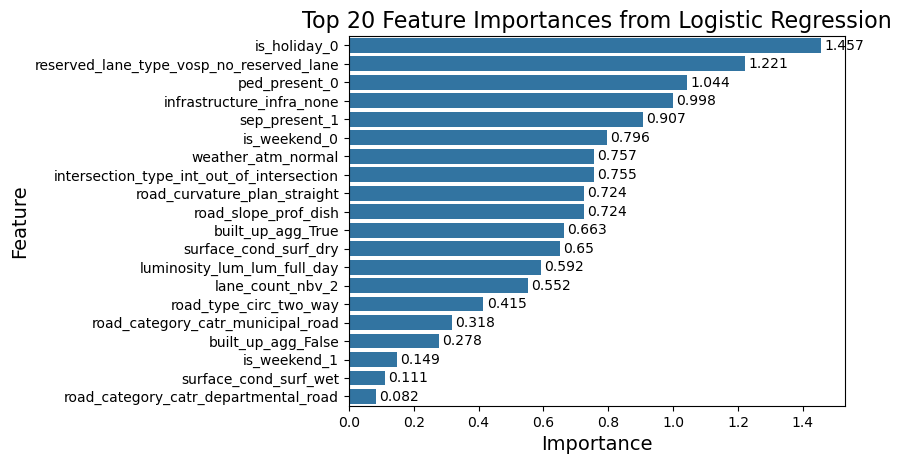

In [218]:
#Plot the top 20 features
plot_top_20_logreg = sns.barplot(data=log_reg_feature_importances.head(20), x='importance', y='feature')

plt.title('Top 20 Feature Importances from Logistic Regression', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Annotate each bar with its importance value
for p in plot_top_20_logreg.patches:
    x = p.get_x() + p.get_width() + 0.01  # Small offset for visibility
    y = p.get_y() + p.get_height() / 2
    
    importance_value = round(p.get_width(), 3)
    plt.text(x, y, str(importance_value), color='black', va='center')

plt.savefig('figures/plot_top_20_logreg.png', bbox_inches='tight', dpi=300)


plt.show()

### Random Forest Feats

In [219]:
rf_feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [220]:
print("Top 10 Random Forest Feature Importances:\n", rf_feature_importances.head(10))

Top 10 Random Forest Feature Importances:
                            Feature  Importance
76                  ped_present_15    0.074160
74                   ped_present_9    0.071232
75                  ped_present_10    0.059042
73                   ped_present_8    0.057516
59           surface_cond_surf_mud    0.056820
70                   ped_present_5    0.056236
71                   ped_present_6    0.055441
69                   ped_present_4    0.054847
72                   ped_present_7    0.049613
54  infrastructure_infra_toll_zone    0.042127


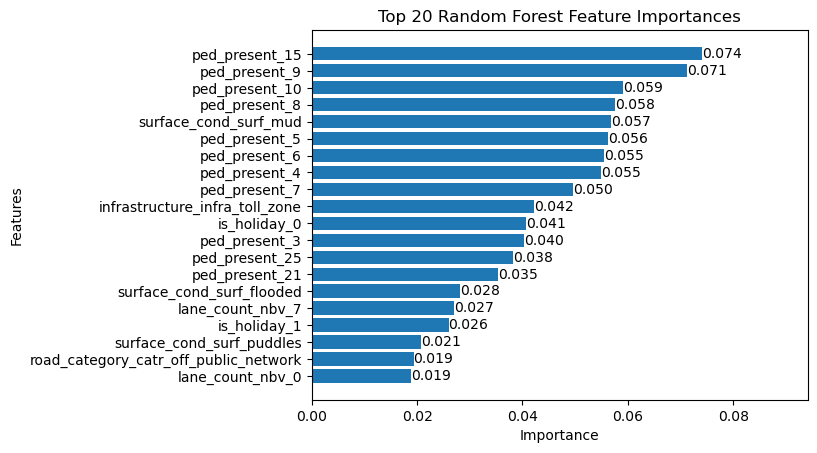

In [221]:
top_rf_features = rf_feature_importances.sort_values(by='Importance', ascending=False).head(20)


plot_top_20_rf = plt.barh(top_rf_features['Feature'], top_rf_features['Importance'], align="center")
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.xlim(0, top_rf_features['Importance'].max() + 0.02)
plt.gca().invert_yaxis()  #invert y-axis to have the most important feature on top

#add Importance Labels to Each Bar
for bar in plot_top_20_rf:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', color='black')

plt.savefig('figures/plot_top_20_rf.png', bbox_inches='tight', dpi=300)

plt.show()

Quote about feature importances from both models:

    "Logistic Regression highlights features that have the strongest linear relationship with the target,
    while Random Forest emphasizes features that are most effective at splitting the data to reduce impurity, potentially capturing more complex patterns and interactions."

## Neural Network Model

    NOTE:
    - The model was built then tuned. The optimal hyperparameters were then saved to 'best_nn_hyperparameters.txt'
    - The model is now being created using the optimal hyperparameters rather than starting from scratch and then tuning to save time in executing the code.
    - The cells for building the model with 'best_nn_hyperparameters.txt' will be marked with "#best params model"

    - If it is desired to run the model and the tuning please convert the cells marked with "#original nn model" back to code cells.

In [222]:
#convert to int since bool doesn't work with this model

X_train = X_train.astype(int)
X_test = X_test.astype(int)

In [223]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    #patience=3 b/c model was stopping at 3rd epoch when patience=2. Personnal choice to see more epochs

### Best Params NN Model
    Model built using 'best_nn_hyperparameters.txt'

In [224]:
#best params model

#Load the hyperparameters from the text file
loaded_hyperparams = {}
with open('best_nn_hyperparameters.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        loaded_hyperparams[key] = value

In [225]:
loaded_hyperparams

{'num_layers': '2',
 'units_0': '288',
 'dropout_0': '0.4',
 'learning_rate': '0.01',
 'tuner/epochs': '2',
 'tuner/initial_epoch': '0',
 'tuner/bracket': '2',
 'tuner/round': '0',
 'units_1': '32',
 'dropout_1': '0.0',
 'activation': 'relu',
 'dropout': 'False',
 'optimizer': 'adam'}

In [226]:
#best params model

#Convert numeric values from file back to appropriate types
    #Chose to convert everything for peace of mind even if the param wouldn't be used

loaded_hyperparams['num_layers'] = int(loaded_hyperparams['num_layers'])
loaded_hyperparams['units_0'] = int(loaded_hyperparams['units_0'])
loaded_hyperparams['dropout_0'] = float(loaded_hyperparams['dropout_0'])
loaded_hyperparams['learning_rate'] = float(loaded_hyperparams['learning_rate'])
loaded_hyperparams['tuner/epochs'] = int(loaded_hyperparams['tuner/epochs'])
loaded_hyperparams['tuner/initial_epoch'] = int(loaded_hyperparams['tuner/initial_epoch'])
loaded_hyperparams['tuner/bracket'] = int(loaded_hyperparams['tuner/bracket'])
loaded_hyperparams['tuner/round'] = int(loaded_hyperparams['tuner/round'])
loaded_hyperparams['units_1'] = int(loaded_hyperparams['units_1'])
loaded_hyperparams['dropout_1'] = float(loaded_hyperparams['dropout_1'])
loaded_hyperparams['activation'] = str(loaded_hyperparams['activation']).strip()
loaded_hyperparams['dropout'] = bool(loaded_hyperparams['dropout'])
loaded_hyperparams['optimizer'] = str(loaded_hyperparams['optimizer']).strip()


loaded_hyperparams['Dropout Rates'] = [float(loaded_hyperparams[f'dropout_{i}']) for i in range(loaded_hyperparams['num_layers'])]
loaded_hyperparams['Units per Layer'] = [loaded_hyperparams[f'units_{i}'] for i in range(loaded_hyperparams['num_layers'])]
loaded_hyperparams['Units per Layer'] = list(map(int, loaded_hyperparams['Units per Layer']))

print("Converted Hyperparameters:")
loaded_hyperparams

Converted Hyperparameters:


{'num_layers': 2,
 'units_0': 288,
 'dropout_0': 0.4,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0,
 'units_1': 32,
 'dropout_1': 0.0,
 'activation': 'relu',
 'dropout': True,
 'optimizer': 'adam',
 'Dropout Rates': [0.4, 0.0],
 'Units per Layer': [288, 32]}

In [227]:
#best params model

def build_nn_model(loaded_hyperparams):
    nn_model = Sequential()

    # Input layer (use shape instead of input_shape)
    nn_model.add(InputLayer(shape=(X_train.shape[1],)))

    # Hidden layers
    for i in range(loaded_hyperparams['num_layers']):
        units = loaded_hyperparams[f'units_{i}']
        nn_model.add(Dense(units, activation=loaded_hyperparams['activation']))
        if loaded_hyperparams['dropout'] == 'True':
            nn_model.add(Dropout(loaded_hyperparams[f'dropout_{i}']))

    # Output layer
    nn_model.add(Dense(1, activation='sigmoid'))

    # Optimizer handling
    optimizer_choice = loaded_hyperparams['optimizer']
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=loaded_hyperparams['learning_rate'])
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=loaded_hyperparams['learning_rate'])
    else:
        optimizer = RMSprop(learning_rate=loaded_hyperparams['learning_rate'])

    nn_model.compile(optimizer=optimizer, 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

    return nn_model

In [228]:
#best params model

nn_model = build_nn_model(loaded_hyperparams)

In [230]:
#best params model

history = nn_model.fit(X_train, y_train, 
                       epochs=50, 
                       batch_size=int(loaded_hyperparams.get('batch_size', 64)), #64 batch size instead of default 32
                       validation_split=0.2, 
                       callbacks=[early_stopping],
                       verbose=1)

Epoch 1/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 1.0000 - loss: 3.7219e-13 - val_accuracy: 1.0000 - val_loss: 5.2783e-13
Epoch 2/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 1.0000 - loss: 3.6689e-13 - val_accuracy: 1.0000 - val_loss: 5.1487e-13
Epoch 3/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 16s 960us/step - accuracy: 1.0000 - loss: 4.6493e-13 - val_accuracy: 1.0000 - val_loss: 5.1713e-13
Epoch 4/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 16s 957us/step - accuracy: 1.0000 - loss: 4.5928e-13 - val_accuracy: 1.0000 - val_loss: 5.1947e-13
Epoch 5/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 16s 969us/step - accuracy: 1.0000 - loss: 3.7889e-13 - val_accuracy: 1.0000 - val_loss: 5.0648e-13
Epoch 6/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 16s 975us/step - accuracy: 1.0000 - loss: 5.0724e-13 - val_accuracy: 1.0000 - val_loss: 5.0875e-13
Epoch 7/50
16555/16555 ━━━━━━━━━━━━━━━━━━━━ 16s 978us/step - accuracy: 1.0000 - loss: 3.6872e-13 - val_accuracy: 1.0000 - val_loss: 5.1104e-13
Epo

### Original NN Model

### NN Model Metrics

In [231]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 288)            │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,437 (540.77 KB)

 Trainable params: 46,145 (180.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,292 (360.52 KB)

In [232]:
y_pred_proba = nn_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

10347/10347 ━━━━━━━━━━━━━━━━━━━━ 5s 514us/step


In [233]:
# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    165549
           1       1.00      1.00      1.00    165548

    accuracy                           1.00    331097
   macro avg       1.00      1.00      1.00    331097
weighted avg       1.00      1.00      1.00    331097

Confusion Matrix:
 [[165549      0]
 [     0 165548]]


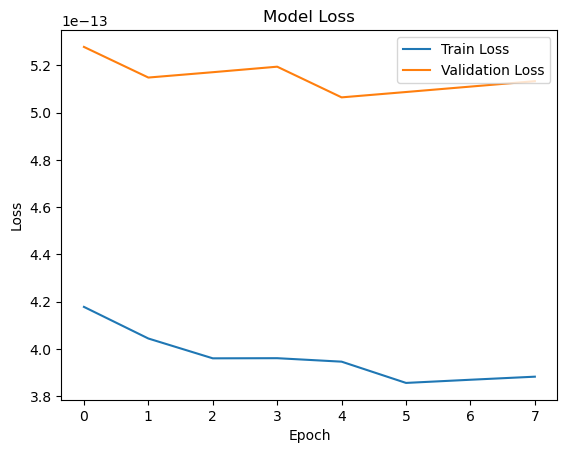

In [234]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

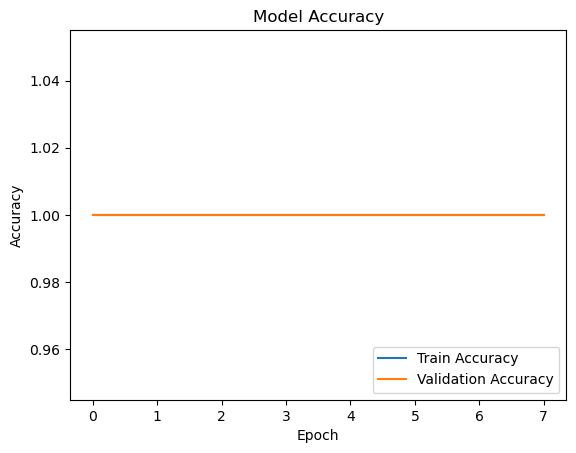

In [235]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Tune the Neural Network Model

    This was performed and the best params were saved to 'best_nn_hyperparameters.txt'

    The cells in this tuning section are converted to raw to prevent execution in order to save time later.

    Convert back into code cells and run as needed

### Save Best Hyperparameters to a Text File
    In order to skip tuning on later runs of this notebook

    Ran once then cells converted to raw format to prevent execution

    Convert to code cell as needed

# Feature Importances of NN Model
    using SHAP analysis

In [236]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Crash', 'Crash'],  # Adjust labels as per your target variable
    mode='classification'
)

In [237]:
def predict_fn(input_data):
    # Ensure input_data is a 2D array
    input_data = input_data.reshape(-1, X_train.shape[1])
    
    # Get the predictions from the model
    predictions = nn_model.predict(input_data)
    
    # For binary classification, predictions will be a single column of probabilities
    if predictions.shape[1] == 1:  # Binary classification
        predictions = np.hstack((1 - predictions, predictions))  # Convert to 2D shape [N, 2]

    return predictions  # Return probabilities

In [238]:
sample_size = 100 #500
sample_indices = np.random.choice(X_test.index, size=sample_size, replace=False)

In [240]:
for index in sample_indices:
    # Explain the prediction for both classes
    exp = explainer.explain_instance(
        X_test.loc[index].values,
        predict_fn,
        labels=[0, 1],
        num_features=20
    )
    
    # Extract feature importance for class 1
    feature_importance_1 = exp.as_list(label=1)  # for class 1
    feature_importance_list.append(feature_importance_1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
157/157 ━━━

In [239]:
feature_importance_list = []

In [241]:
flat_importance = []
for sublist in feature_importance_list:
    for feature, importance in sublist:
        flat_importance.append((feature, importance))

In [242]:
# Create a DataFrame from the flattened list
importance_df = pd.DataFrame(flat_importance, columns=['Feature', 'Importance'])

In [243]:
# Group by feature and calculate the mean importance
mean_importance = importance_df.groupby('Feature').mean().reset_index()
mean_importance = mean_importance.sort_values(by='Importance', ascending=False).head(20)

In [244]:
mean_importance.head()

,Feature,Importance
15,0.00 < is_holiday_0 <= 1.00,0.081537
67,intersection_type_int_place <= 0.00,0.074607
1,0.00 < built_up_agg_True <= 1.00,0.073807
93,ped_present_8 <= 0.00,0.072097
84,ped_present_21 <= 0.00,0.071635


In [245]:
#remove the extra characters from the feature names
characters_to_remove = r'[<>0.01 0.00 1.00 =]'

mean_importance['Feature'] = mean_importance['Feature'].str.replace(characters_to_remove, '', regex=True)
mean_importance['Feature'] = mean_importance['Feature'].str.strip()

mean_importance.head()

,Feature,Importance
15,is_holiday_,0.081537
67,intersection_type_int_place,0.074607
1,built_up_agg_True,0.073807
93,ped_present_8,0.072097
84,ped_present_2,0.071635


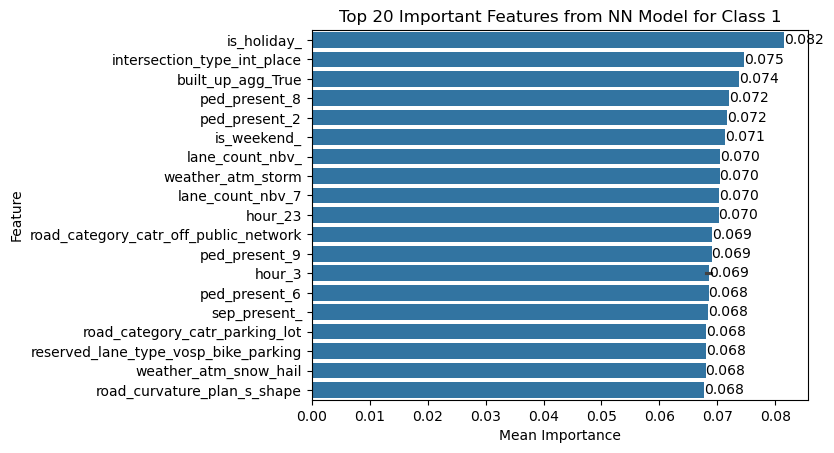

In [248]:
plot_top_20_nn = sns.barplot(x='Importance', y='Feature', data=mean_importance)
plt.title('Top 20 Important Features from NN Model for Class 1')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')

for bar in plot_top_20_nn.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', color='black')

plt.savefig('figures/plot_top_20_nn.png', bbox_inches='tight', dpi=300)

plt.show()

# Compare top 20 Feature Importances from all 3 models

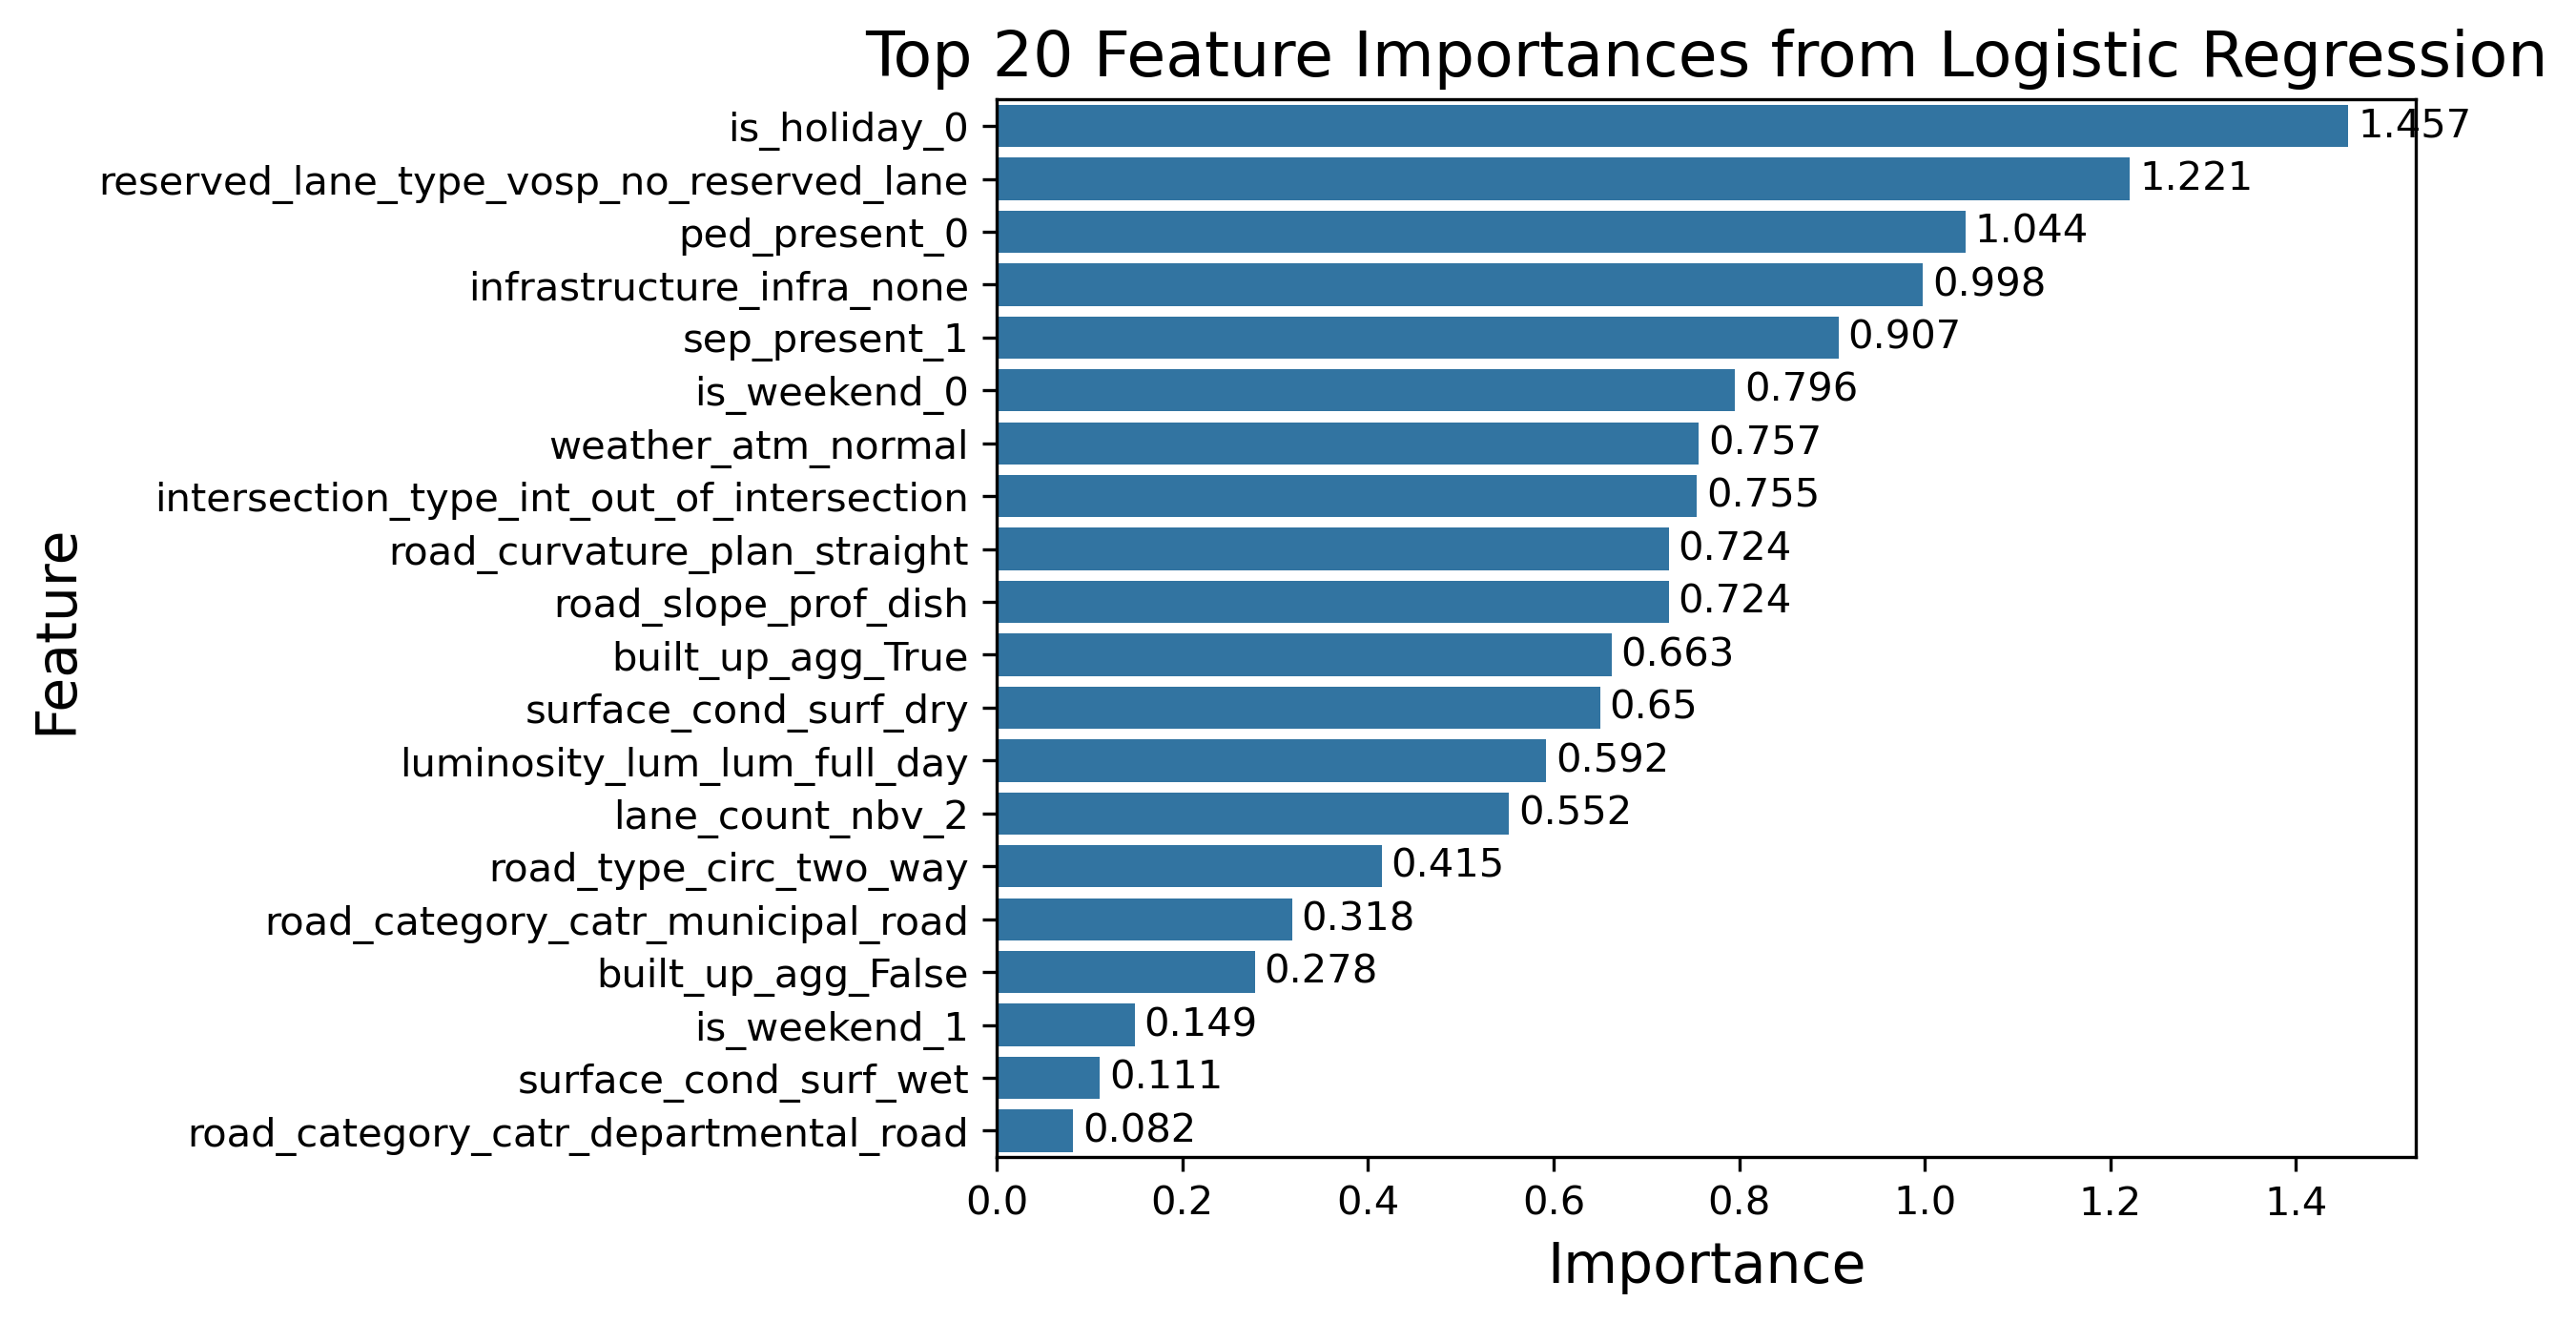

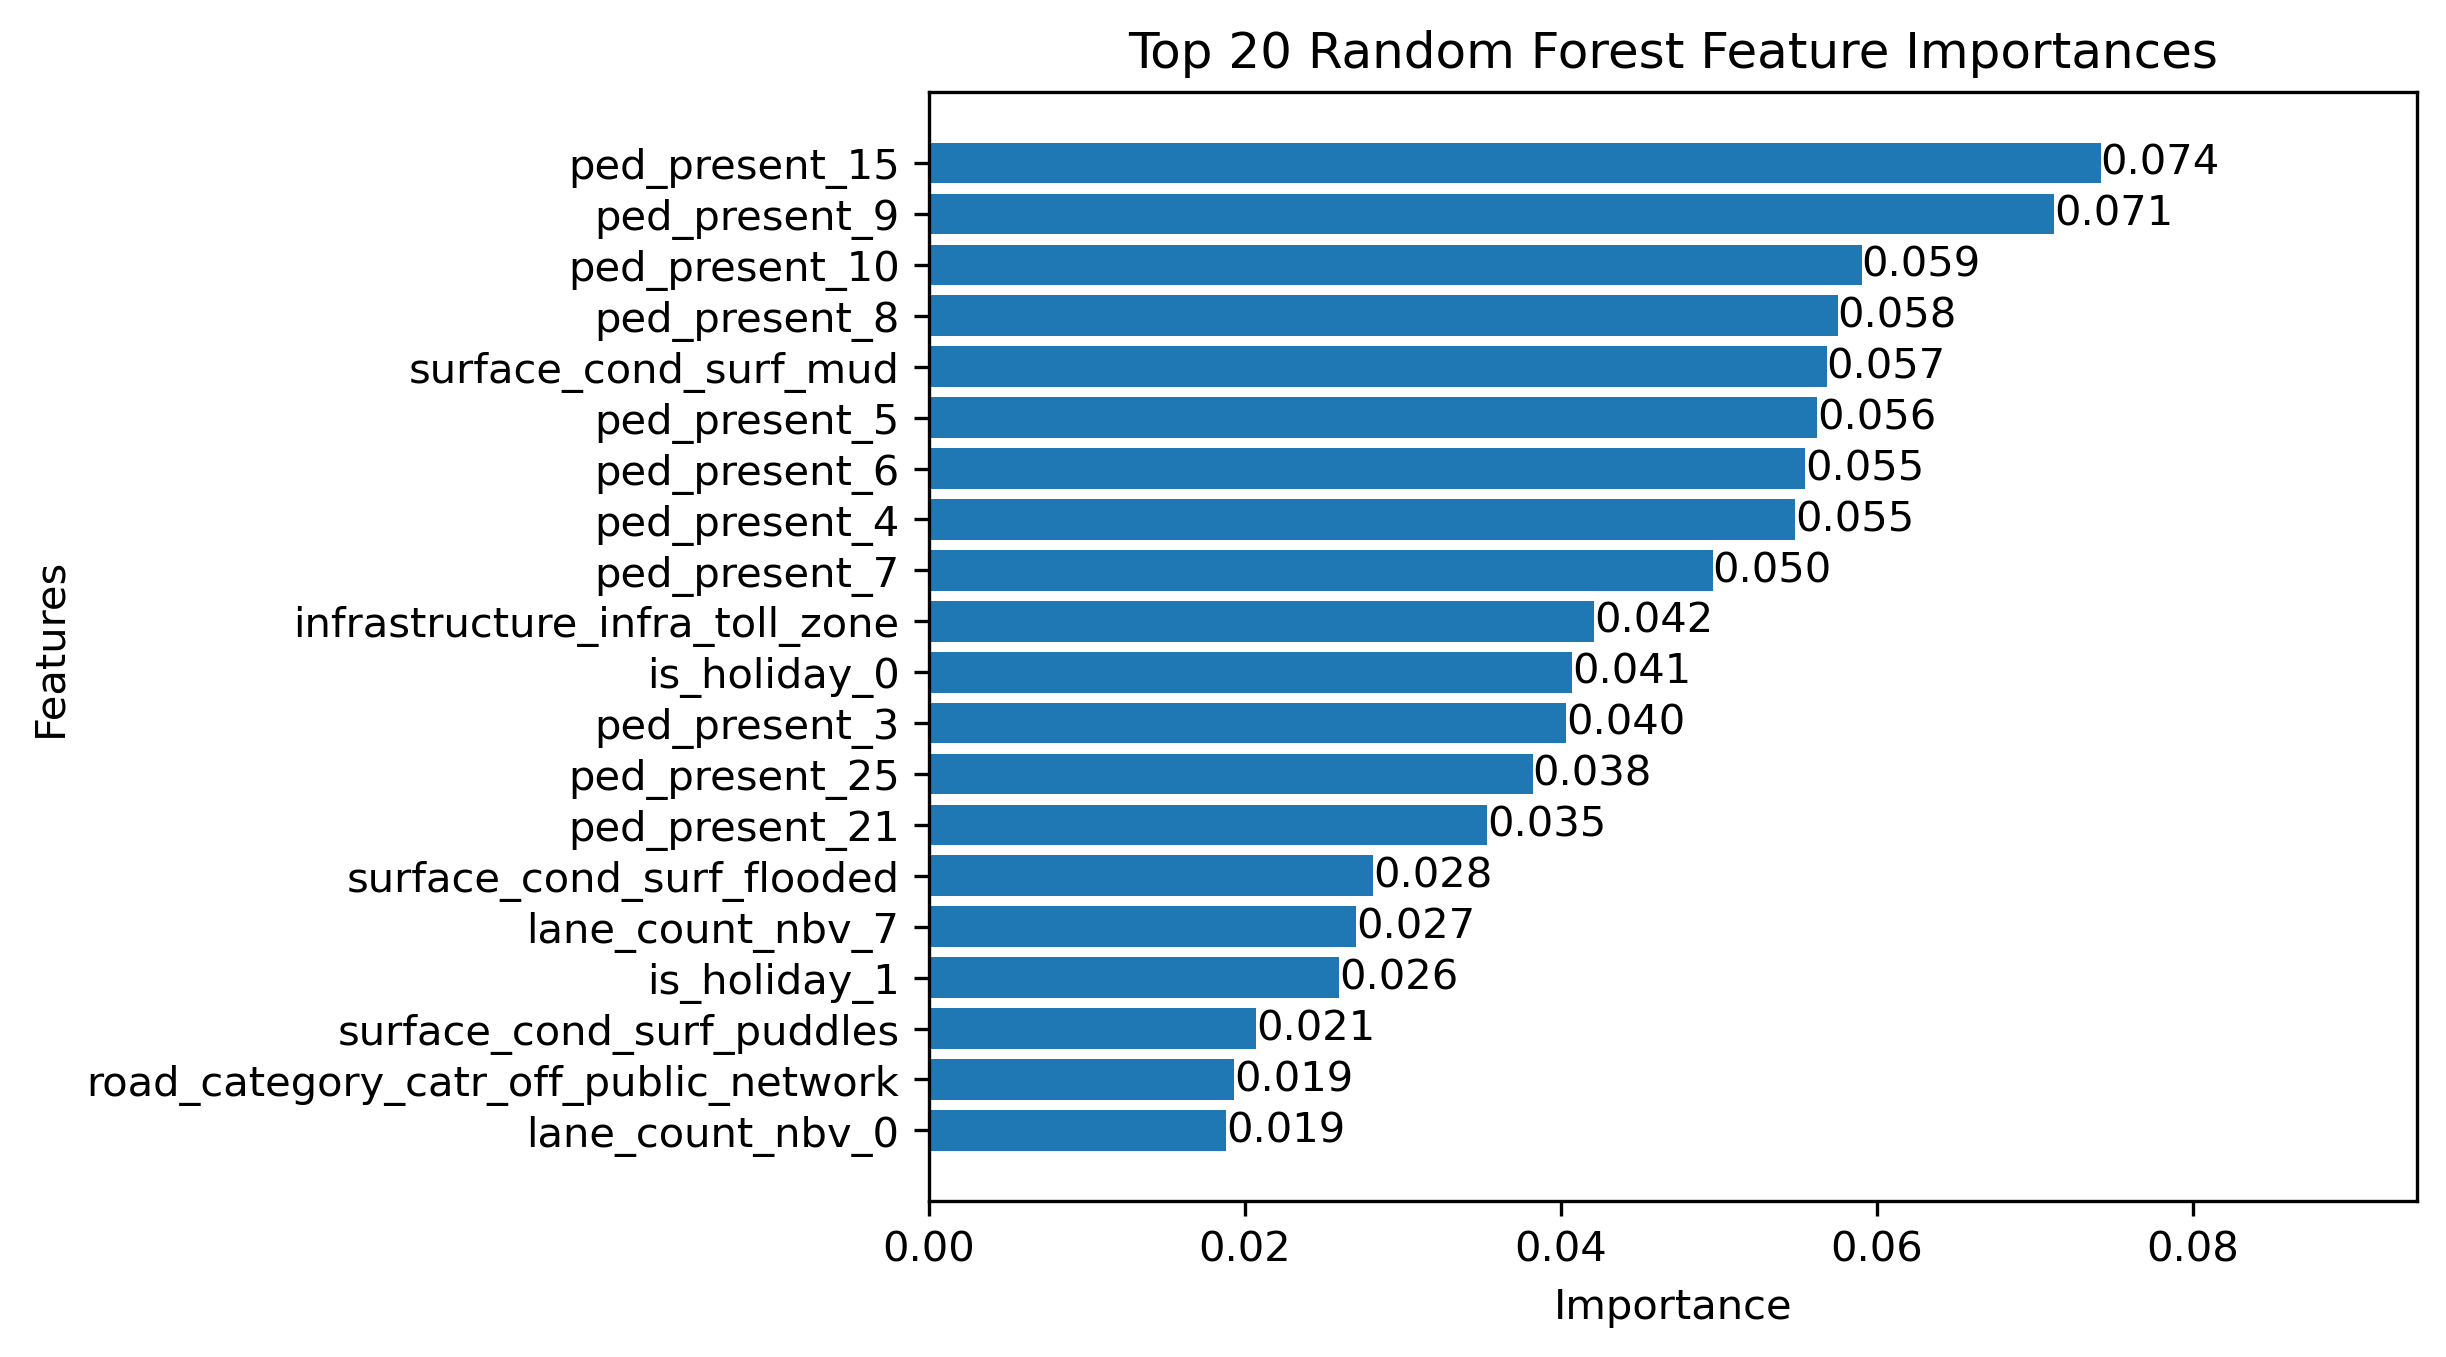

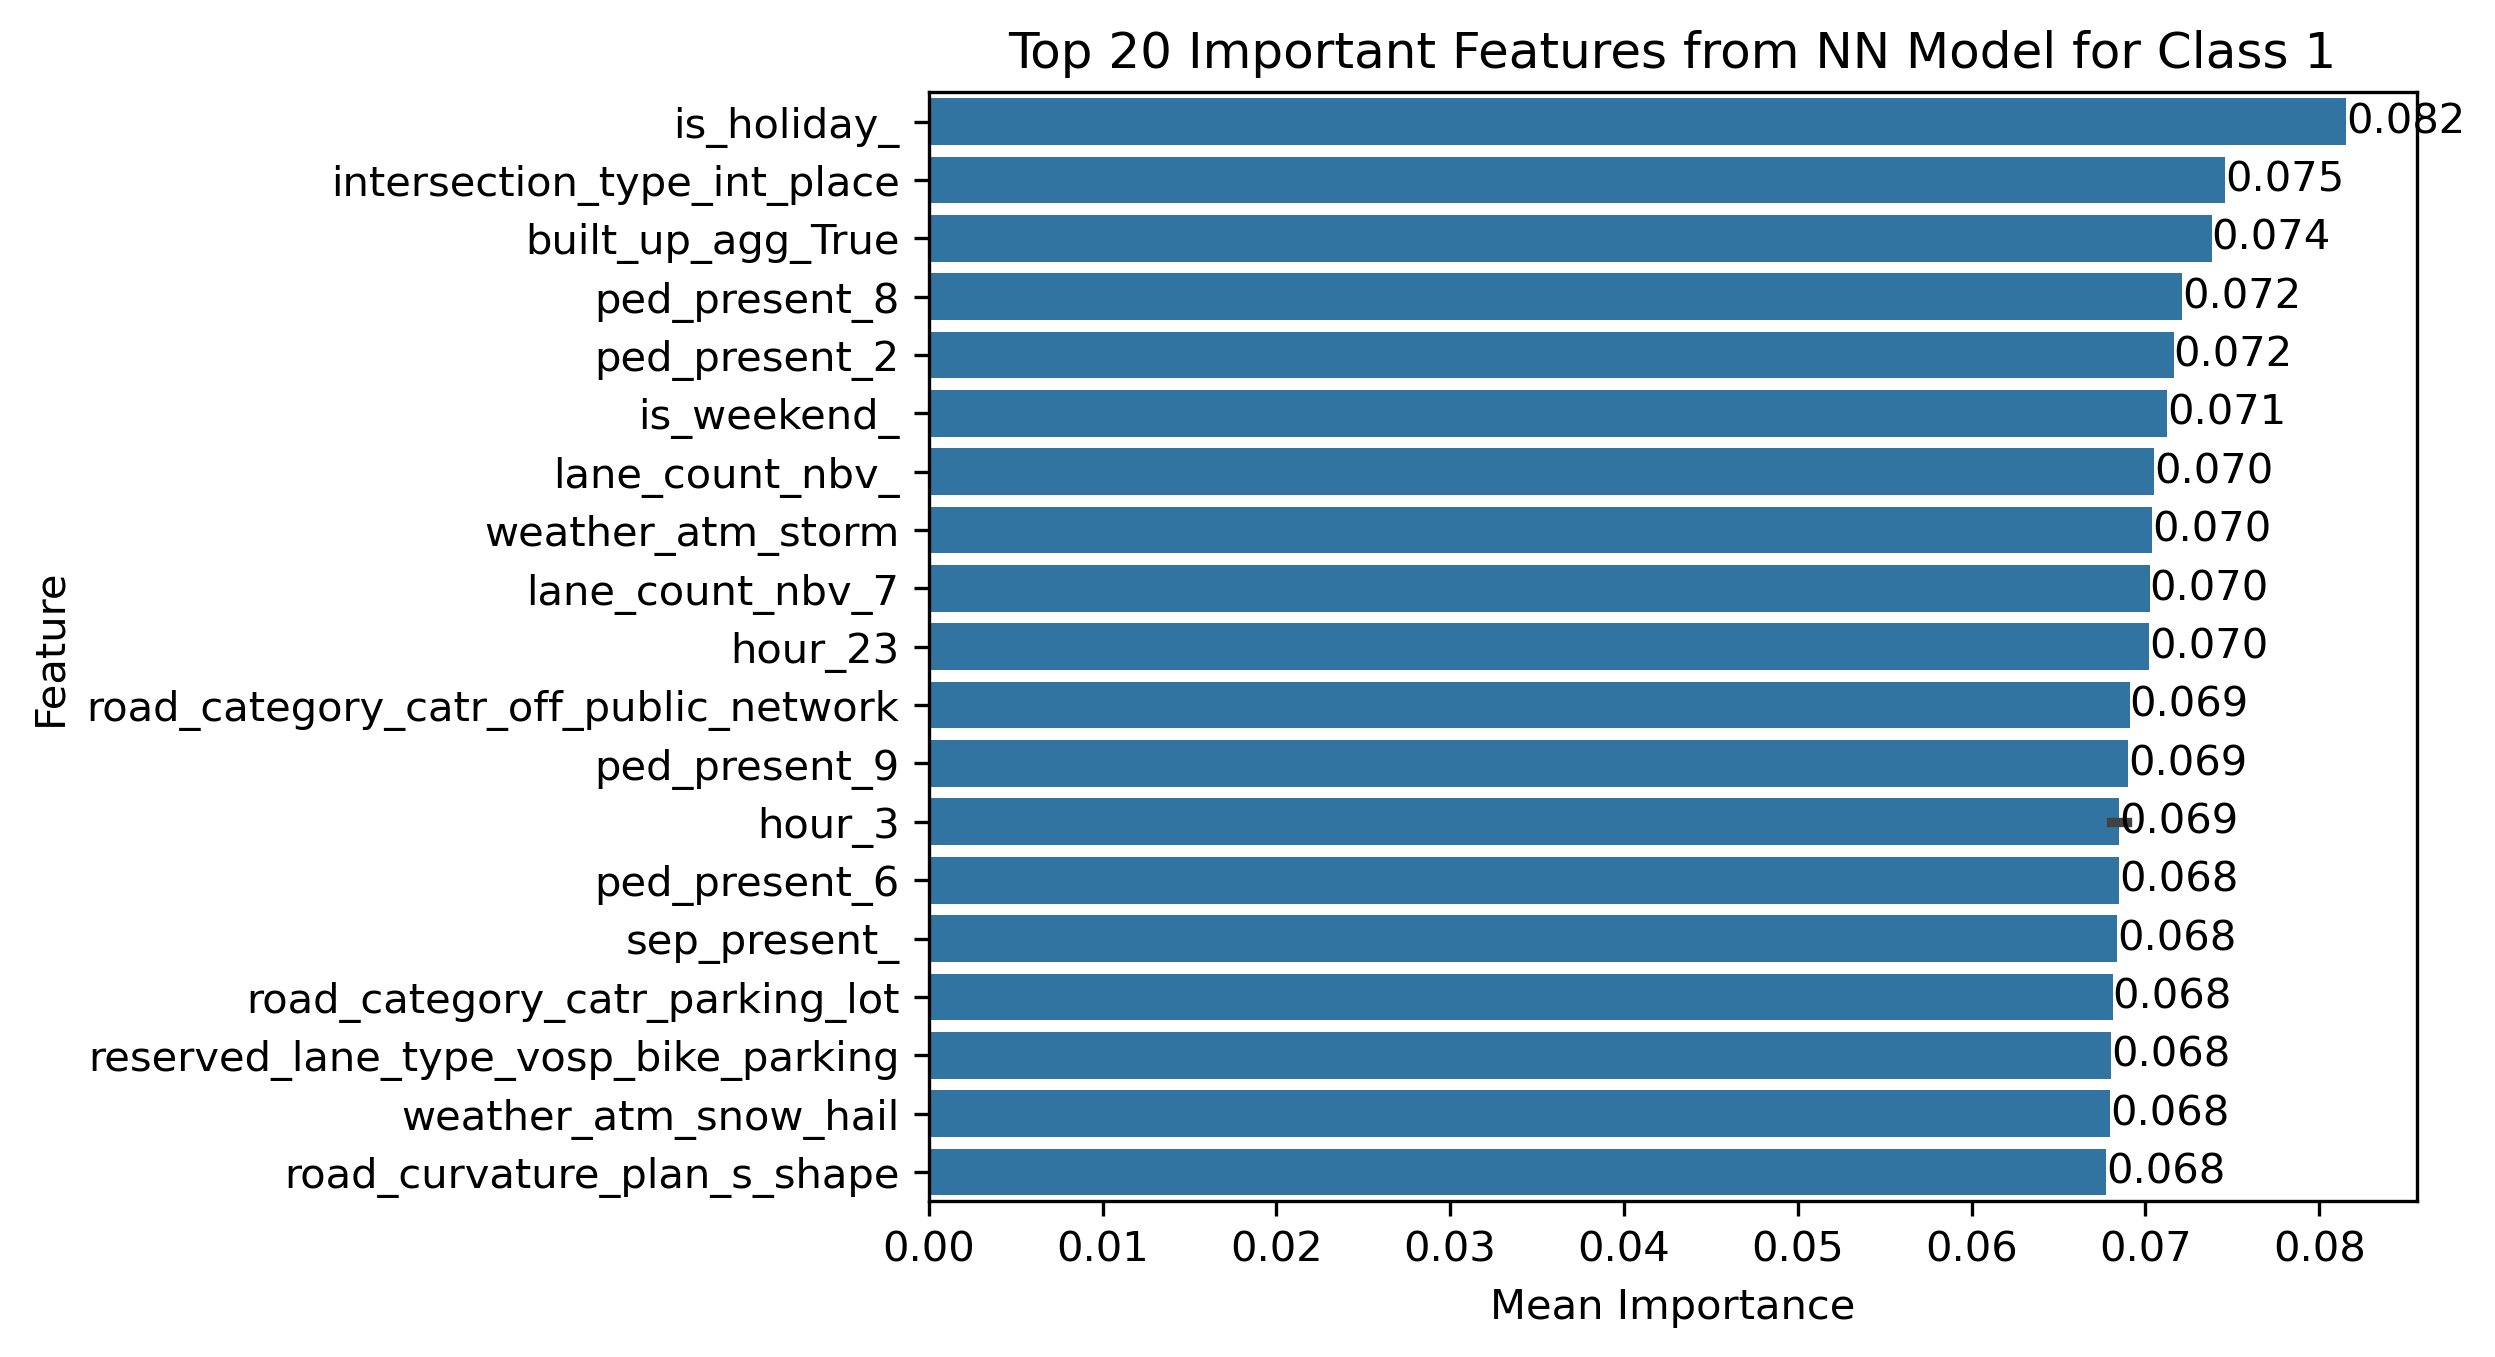

In [249]:
display(Image(filename='figures/plot_top_20_logreg.png'))
display(Image(filename='figures/plot_top_20_rf.png'))
display(Image(filename='figures/plot_top_20_nn.png'))